# Natural Language Processing & Advanced Machine Learning Project 1
<h2>Task</h2>
<b>The goal of the project is to provide a data text synthesis of a massive corpora of scientific articles about natural language processing.</b>

<h2>Initial Data</h2>
Corpus TALN : CLLE - Cognition, Langue, Langages, Ergonomie - UMR 5263 (Toulouse, FR)
<br>
<br>
<b>Corpus TALN</b> brings together the papers from the TALN and RECITAL conferences from 1997 to 2019. It is composed of 1602 scientific articles in French dealing with the field of automatic language processing (ALP) for a total of 5.8 million words.


## Mount Drive (if working on Google Drive)
To access the files in the folder, and retrieve the XML file.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import library 

We import some libraries :

### For the scrapping : 
*   **BS4 Beautiful Soup**, Python library for pulling data out of HTML and XML files. It works with your favorite parser to provide idiomatic ways of navigating, searching, and modifying the parse tree.
*   **Regex**, This module provides regular expression matching operations similar to those found in Perl.
*   **lxml**, the most feature-rich and easy-to-use library for processing XML and HTML in the Python language.
*   **pandas**. pandas is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language.
*   **numpy**, is an extension of the Python programming language, designed to manipulate multidimensional matrices or arrays as well as mathematical functions operating on these arrays.


In [2]:
from bs4 import BeautifulSoup
import regex as re
import lxml
import pandas as pd
import numpy as np

### For the data exploration :
*   **Matplotlib**, Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python.

In [3]:
import matplotlib.pyplot as plt

### For the Term frenquency analysis and for the preprocessing:


*   **NLTK**, NLTK is a leading platform for building Python programs to work with human language data.




In [4]:
from nltk import RegexpTokenizer
from collections import Counter
from wordcloud import WordCloud

### For the clustering of articles:

*   **sklearn**,  is a free Python library for machine learning. In our case, we'll use it to perform KMeans algorithm, and also to have access to already implemented metrics.

*   **FrenchStemmer**, is a stemmer already implemented by **NLTK** to stem French corpus. Stemming is the process of reducing inflection in words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid word in the Language.

*   **TFidfVectorizer**, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. 

*   **mplot3d** is a toolkit which adds simple 3D plotting capabilities to matplotlib by supplying an axes object that can create a 2D projection of a 3D scene.

In [5]:
from nltk.stem.snowball import FrenchStemmer
stemmer = FrenchStemmer()

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist, cosine
from sklearn.manifold import MDS

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

### For the word embeddings:
*   **Fasttext**, fastText is a library for learning of word embeddings and text classification created by Facebook's AI Research lab.

In [6]:
!pip3 install fasttext

     |████████████████████████████████| 71kB 4.2MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3041584 sha256=f2bc39233d150dcc960dc698f7f840060d22ba4c84ad90e08cae7448e5ef4e07
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


In [10]:
import fasttext
import fasttext.util

#Pretrained model in French
ft = fasttext.load_model('data/cc.fr.300.bin')

print('Dimension of the embeddings: ',ft.get_dimension())

Dimension of the embeddings:  300


### For the Auto-summarizer

In [11]:
!pip install distance

     |████████████████████████████████| 184kB 9.3MB/s 
  Created wheel for distance: filename=Distance-0.1.3-cp36-none-any.whl size=16262 sha256=1773fb2a1ace2584bdd245880fd98cc2fe0aa822532af2e39efb9e02ef0b59e4
  Stored in directory: /root/.cache/pip/wheels/d5/aa/e1/dbba9e7b6d397d645d0f12db1c66dbae9c5442b39b001db18e
Successfully built distance


In [12]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [13]:
from itertools import combinations
from operator import itemgetter

from distance import jaccard
from networkx import Graph, pagerank

from nltk import corpus, tokenize, stem

## Scrapping from the XML Source

### Retrieve and open the XML, to return a soup containing the XML code

In [15]:
#Retrieve the drive path to the XML file
infile = open("data/corpus_taln_v1.tei.xml","r", encoding='utf-8')
contents = infile.read()

#XML to soup
soup = BeautifulSoup(contents,'html.parser')

### Organize the data into a dataframe to make further analysis

In [16]:
#Text scrapper
text_list = soup.find_all('tei')
print('Number of text : ',len(text_list))

#Abstract scrapper
selector = {'type':'abstract', 'xml:lang':['fr','en']}
abstract = soup.find_all('div', selector)
print('Number of abstract :',len(abstract))



Number of text :  1602
Number of abstract : 3204


In [17]:
def replace_many_char(text):
  """Function to replace \n \r and other characters in the list below"""
  for ch in ['\n','\r']:
    if ch in text:
      text = text.replace(ch," ")
    

    return text

def replace_space(text):
  """Function to delete space in a text"""
  return text.replace(' ', "")

#Definition of the overview dataframe for the exploration and the clustering
columns_df = ['Article', 'French Abstract', 'English Abstract', 'French Keywords', 'English Keywords', 'Title', 'Author','Email', 'Place', 'Date']
df_article = pd.DataFrame(columns = columns_df)

for text in text_list:
    #Article
    body_art = replace_many_char(text.find('body').get_text())
    
    #Abstract
    selector_fr = {'type':'abstract', 'xml:lang':'fr'}
    selector_en = {'type':'abstract', 'xml:lang':'en'}
    
    #Keywords
    selector_keyword_fr = {'type':'keywords', 'xml:lang':'fr'}
    selector_keyword_en = {'type':'keywords', 'xml:lang':'en'}
    
    #Date
    date = text.find('publicationstmt').find('date').get_text()
    
    #Title
    title = replace_many_char(text.find('title').get_text())
    
    #Author
    try:
      author = replace_many_char(text.find('author').find('name').get_text())
    except: 
      author = 'None'
    
    #Email
    try:
      email = replace_space(replace_many_char(text.find('author').find('email').get_text()))
    except: 
      email = 'None'

    #Place
    place = text.find('publicationstmt').find('pubplace').get_text()

    #GetText
    abstract_art_fr = replace_many_char(text.find('div', selector_fr).get_text())
    abstract_art_en = replace_many_char(text.find('div', selector_en).get_text())
    
    keyword_fr = replace_many_char(text.find('div', selector_keyword_fr).get_text())
    keyword_en = replace_many_char(text.find('div', selector_keyword_en).get_text())

    

    
    #Append each article into the dataframe
    df_article = df_article.append(pd.DataFrame([[body_art, abstract_art_fr, abstract_art_en, keyword_fr, keyword_en, title, author, email, place, date]],columns = columns_df), ignore_index =True)

Returns the first 5 rows of the dataframe to visualize it 

In [18]:
df_article.head()

Article  ...  Date
0     Architecture globale du système   Le modèle...  ...  1997
1      Introduction   Dans le domaine de l'ingéni...  ...  1997
2                                                     ...  1997
3     Introduction   La « Théorie des Représentat...  ...  1998
4     Introduction   TAG est un formalisme initia...  ...  1998

[5 rows x 10 columns]

In [19]:
df_article.to_csv('clean.csv')

## Data Exploration

In this second part we will observe the different features parsed that can provide information and knowledge on all the items making up the dataset.

### Composition exploration
First we will make a comparison between the english and the french features in the data.
Let's plot a count without the missing values, to see the composition of the dataset, lets observe the :


*   Article
*   French Abstract
*   English Abstract
*   French Keywords
*   English Keywords

In [20]:
def isnan(string1):
  string1 = string1.strip()
  if string1 == 'None' or string1 == '':
    return True
  return False

df_article_value = pd.DataFrame()
for col in ['Article','French Abstract', 'English Abstract', 'French Keywords', 'English Keywords']:
  df_article_value[col] = df_article[col].apply(lambda x: isnan(x))
df_article_value['Date'] = df_article['Date']
df_article_count = df_article_value.groupby(df_article_value["Date"]).apply(lambda x: x[x == False].count())
df_article_count.drop(['Date'], axis=1, inplace=True)

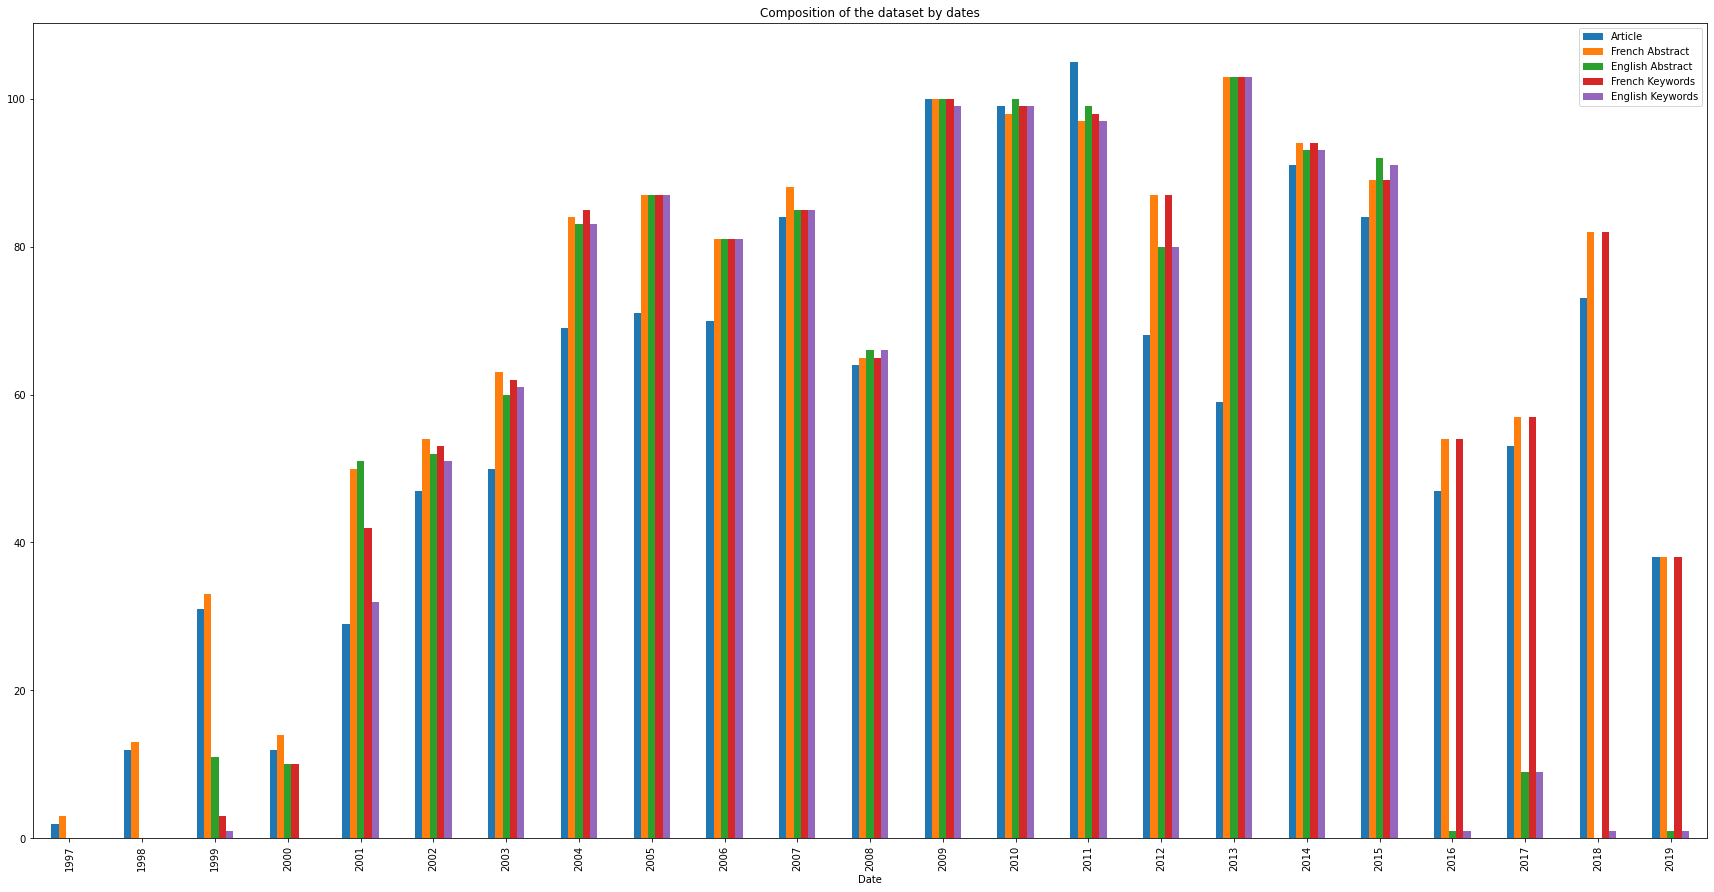

In [21]:
df_article_count.plot(kind='bar', figsize=(30,15), title='Composition of the dataset by dates')

We observe that the composition of a feature is different from one to the other.

Let's observe the difference between French (Abstract & Keywords) and English.

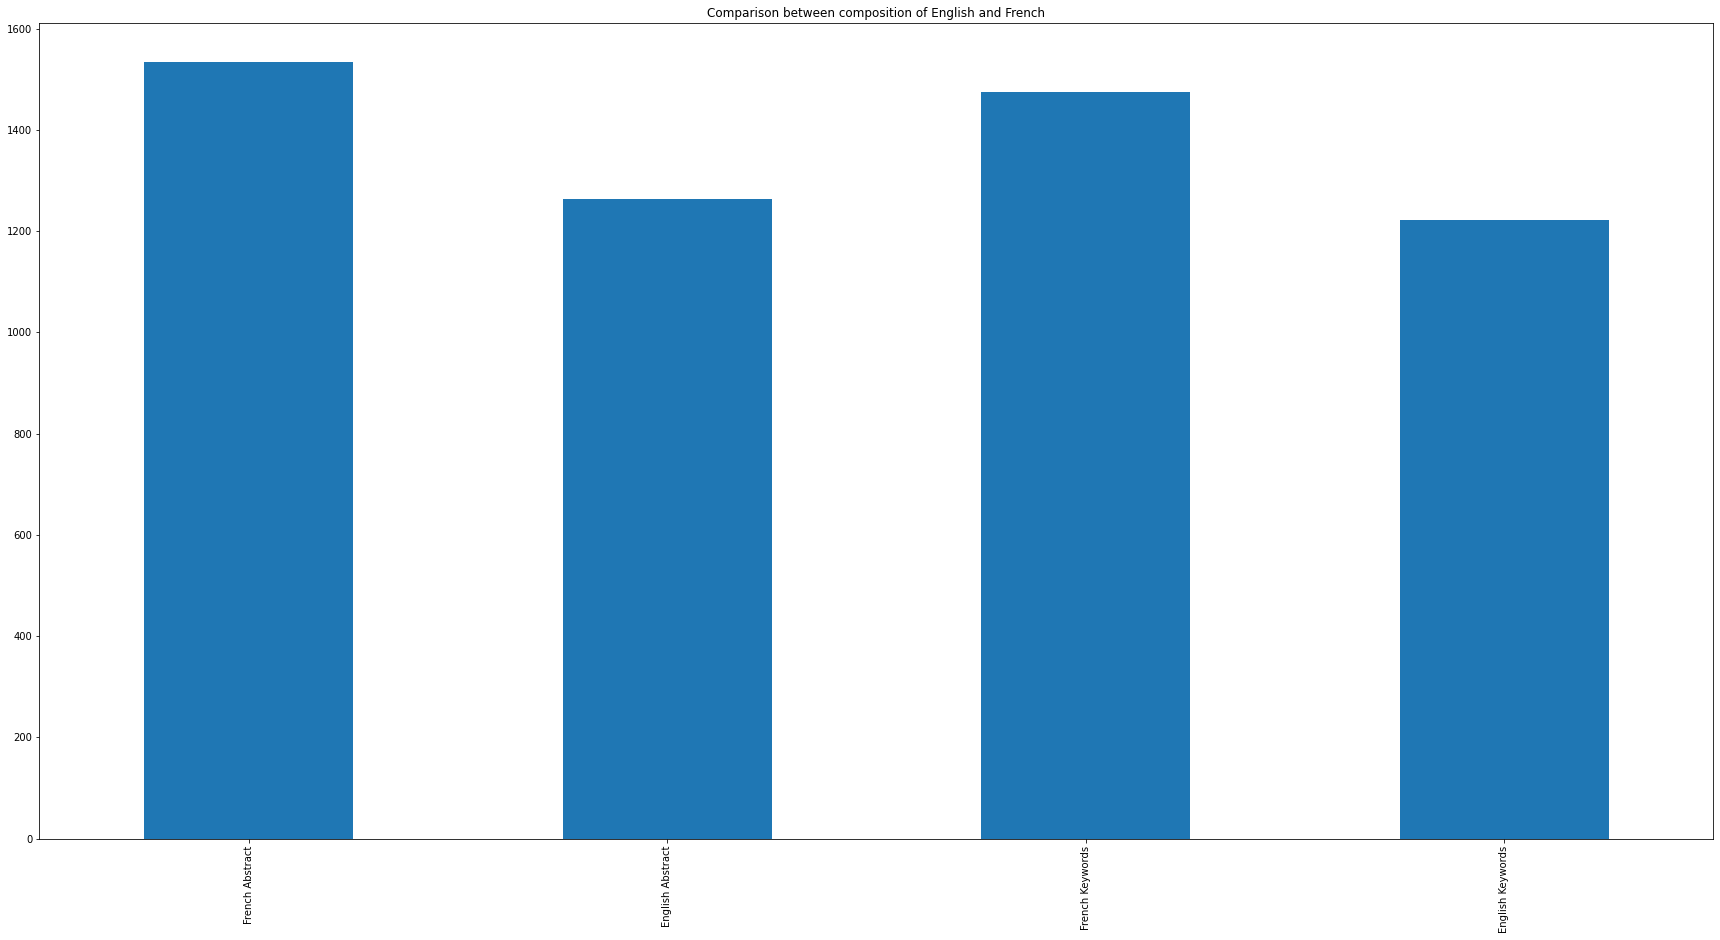

In [22]:
df_article_count.sum(numeric_only=True).drop(['Article']).plot(kind='bar',figsize=(30,15), title='Comparison between composition of English and French')

We observe that we have more information in French. We will use this language for our data exploration and for the clustering.

### Author exploration

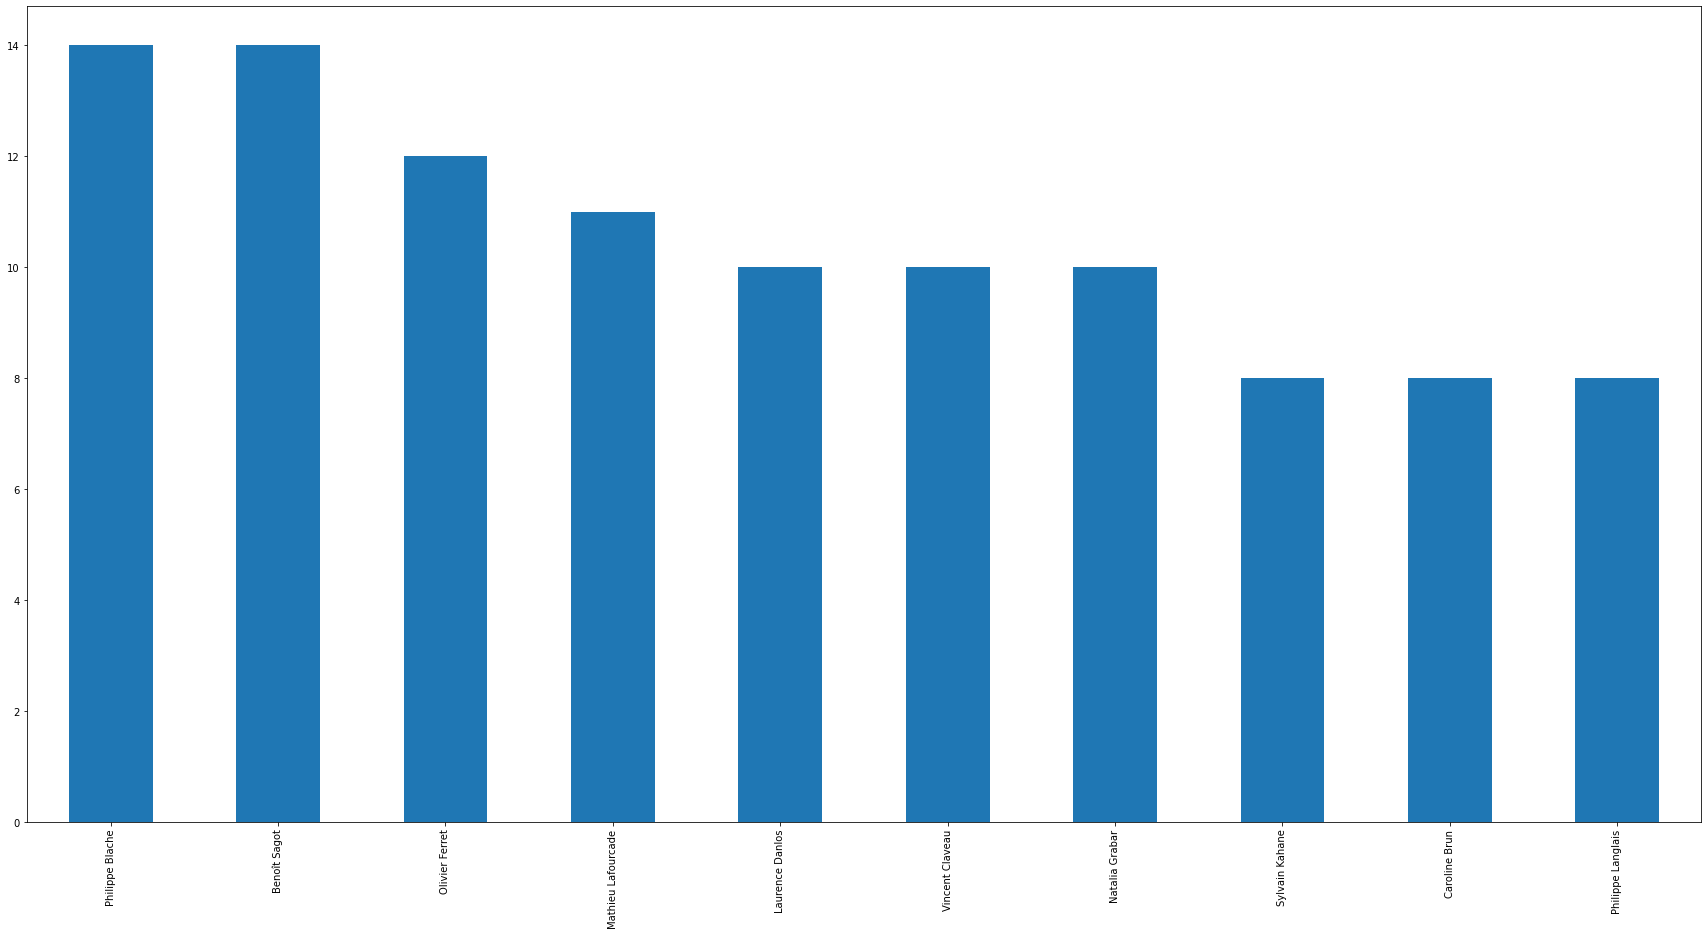

In [23]:
author_value = df_article['Author'].value_counts()
author_value.drop(labels=['None']).head(10).plot(kind='bar', figsize=(30,15))

We have observed the most represented author in the dataset :


1.   **Benoit Sagot**
2.   **Phillippe Blache**
3.   **Olivier Ferret**



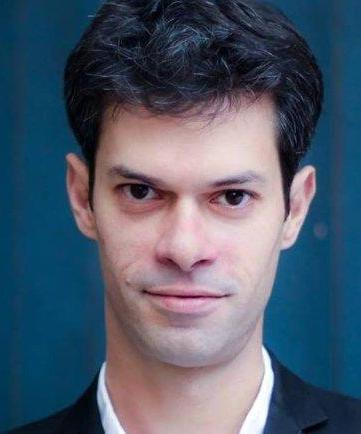

Benoit Sagot is the mosr represented author in the articles, It's an Inria Senior Researcher in Computational Linguistics and Natural Language Processing
Head of the ALMAnaCH research team

### Email exploration

Observing the email we will try to identify the most represented laboratory in the data set, retrieving the domain name.

In [24]:
def email_domain(email_address):
  """Retrieve the email domain using the regex expression"""
  try:
    email_regex = re.search("@(.*)$", email_address)
    email_regex = email_regex.group(0).replace('@','')
    email_regex = email_regex.replace('.com','')
    email_regex = email_regex.replace('.fr','')
    return email_regex
  except:
    return 'None'

In [25]:
df_article['Email'] = df_article['Email'].apply(lambda x: email_domain(x))

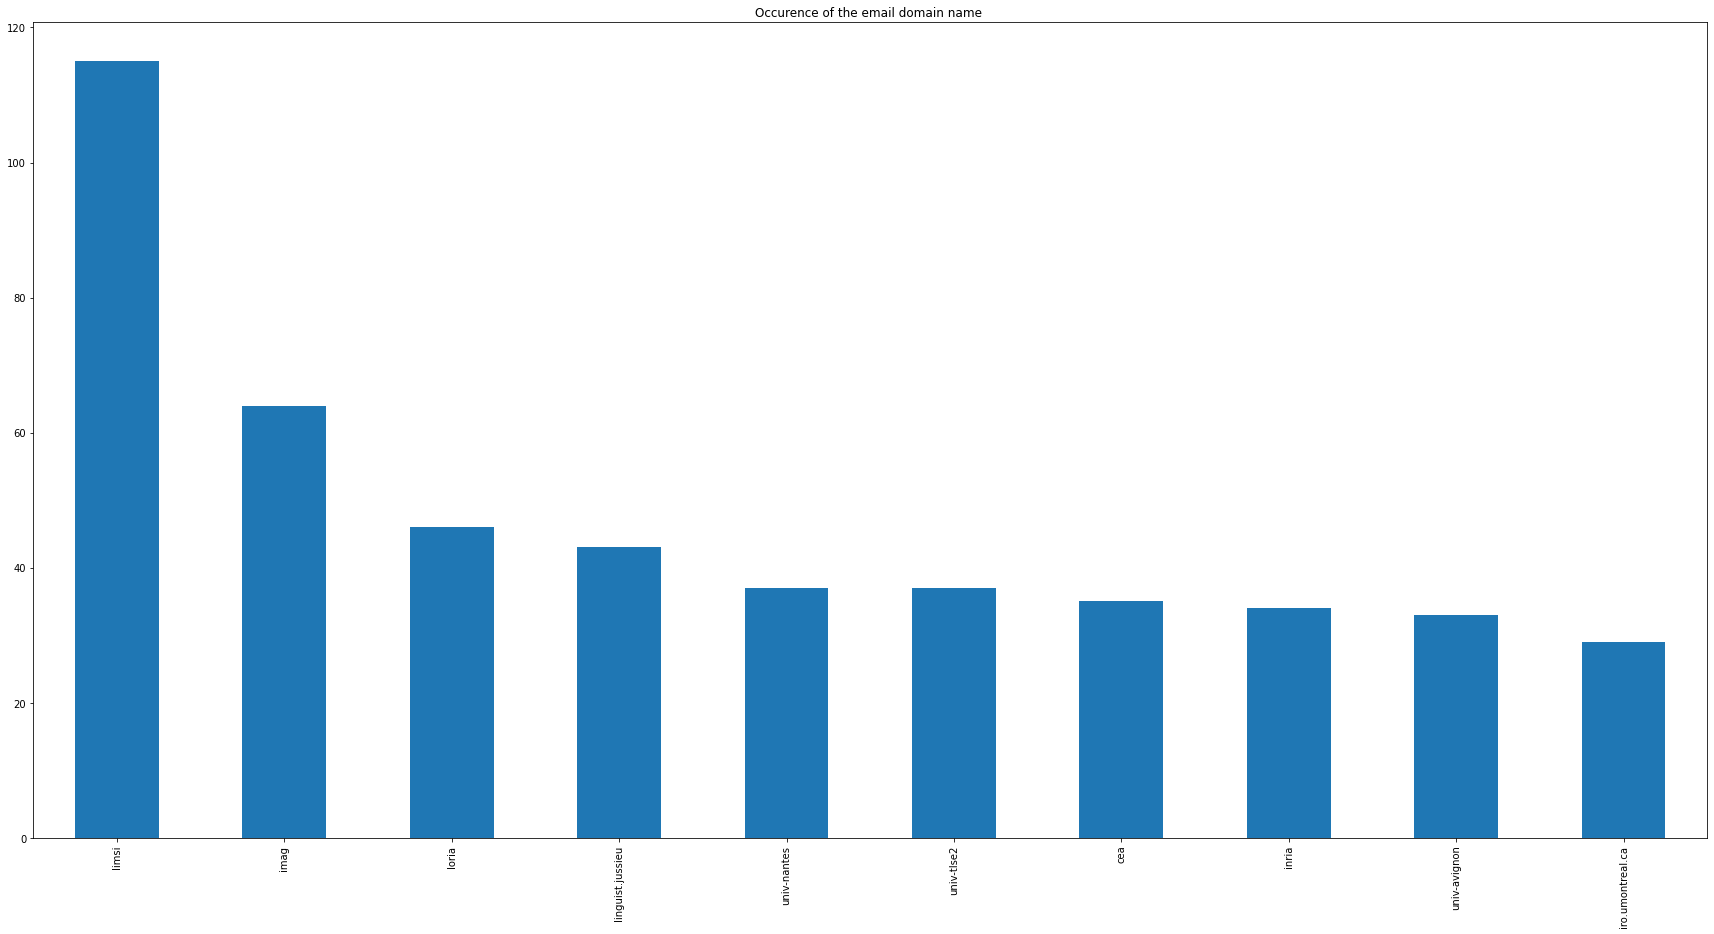

In [26]:
email_value = df_article['Email'].value_counts()

email_value.drop(labels=['gmail', 'None']).head(10).plot(kind='bar', figsize=(30,15), title='Occurence of the email domain name ')

We have observed the domain name in the email address to have an idea about the laboratory of each authors, here is the list of the most represented laboratory.

1.   **LIMSI**, Le Laboratoire d'informatique pour la mécanique et les sciences de l'ingénieur est une unité propre de recherche du Centre national de la recherche scientifique. Composante de l'université Paris-Saclay au sein de la faculté des Sciences d'Orsay.
2.   **IMAG**, Le Laboratoire d’Informatique de Grenoble
3.   **LORIA**, Le Laboratoire lorrain de Recherche en Informatique et ses Applications est une Unité Mixte de Recherche
4.   **Laboratoire de Linguistique de Jussieu**
5.   **Laboratoire de l'université de Nantes**





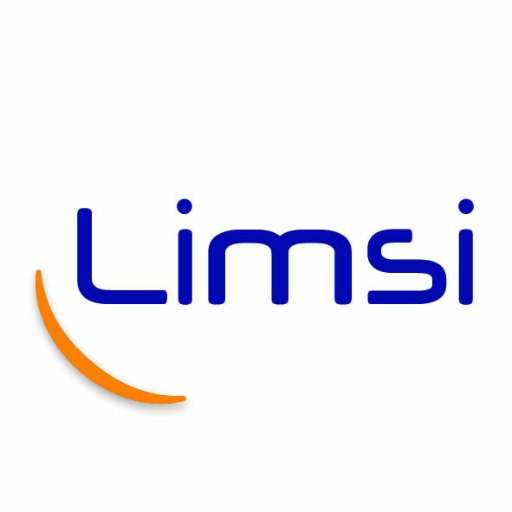

### Term Frenquency Analysis

Let's observe the word distribution in the article dataset.

Tokenization: We use a regex tokenizer, this is more adapted to handle particularity of french language.

In [29]:
def clean_token(text):
    text = re.sub(r'[^\w\s]',' ',text)
    return text

def stopwords_file(file_path):
    """Take a file and return a stopwords list"""
    #Modified stopwords
    with open(file_path,'r',encoding='utf-8') as file_in:
        lines = []
        for line in file_in:
            line = line.replace('\n','')
            lines.append(line)
    advanced_stopwords = set(lines)
    return advanced_stopwords

def clean_stopword(token_list):
    stopwords_for_review = stopwords_file('data/StopWords.txt')
    token_list = [word for word in token_list if word not in stopwords_for_review]
    return token_list


def pre_process(text):

    # Remove Mentions
    text = re.sub(r'@\w+', '', text)

    # Lowercase the document
    text = text.lower()

    #Clean punctuation
    text = clean_token(text)

    #Remove digit
    text = ''.join([i for i in text if not i.isdigit()]) 

    # Remove the doubled space
    text = re.sub(r'\s{2,}', ' ', text)

    
    return text

def tokenization(text):
  #Tokenizer
  tokenizer = RegexpTokenizer(r'''\w'|\w+|[^\w\s]''')

  #Preprocess the text
  result = pre_process(text)

  #tokenizer
  result = tokenizer.tokenize(result)

  #Remove the stopwords
  result = clean_stopword(result)
  return result

In [30]:
df_article['Article Tokens'] = df_article['Article'].apply(lambda x: tokenization(x))
df_article['Article Length'] = df_article['Article Tokens'].apply(lambda x: len(x))

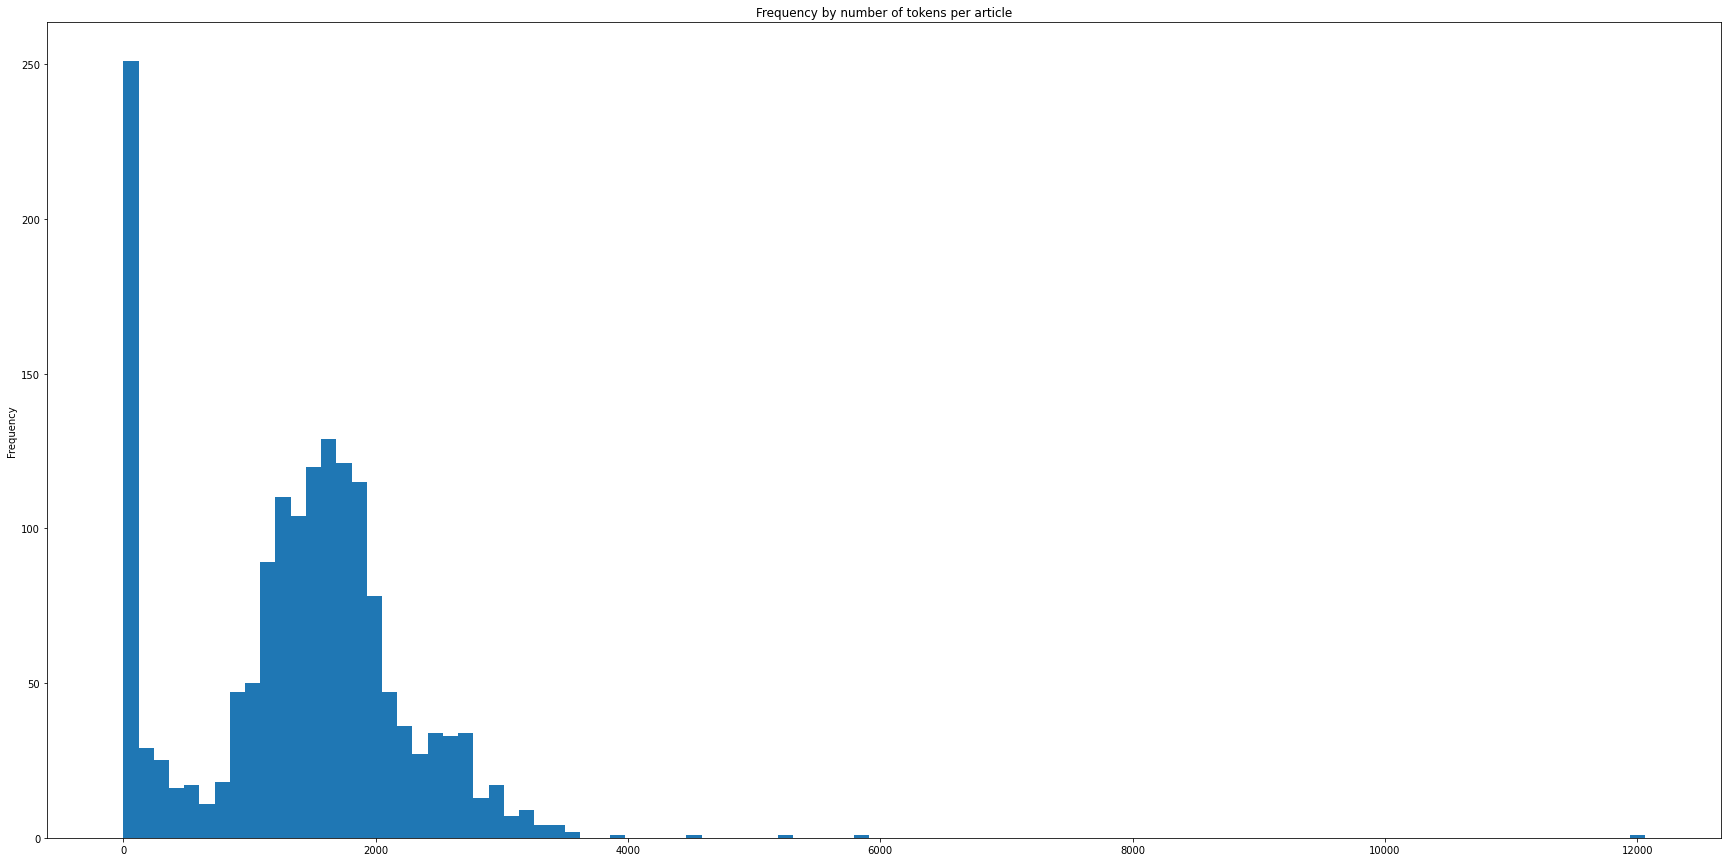

In [31]:
df_article['Article Length'].plot(kind='hist', title='Frequency by number of tokens per article', figsize=(30,15), bins=100)

We observe a large quantity of article with a number of tokens inferior at 100, this is explained by the fact that some article tag doesn't have the content of the article.
Neglecting this we observe the majority of the articles having 1600 tokens. The distribution seems to be almost normal with a bell shaped curve fitting in the histogram.

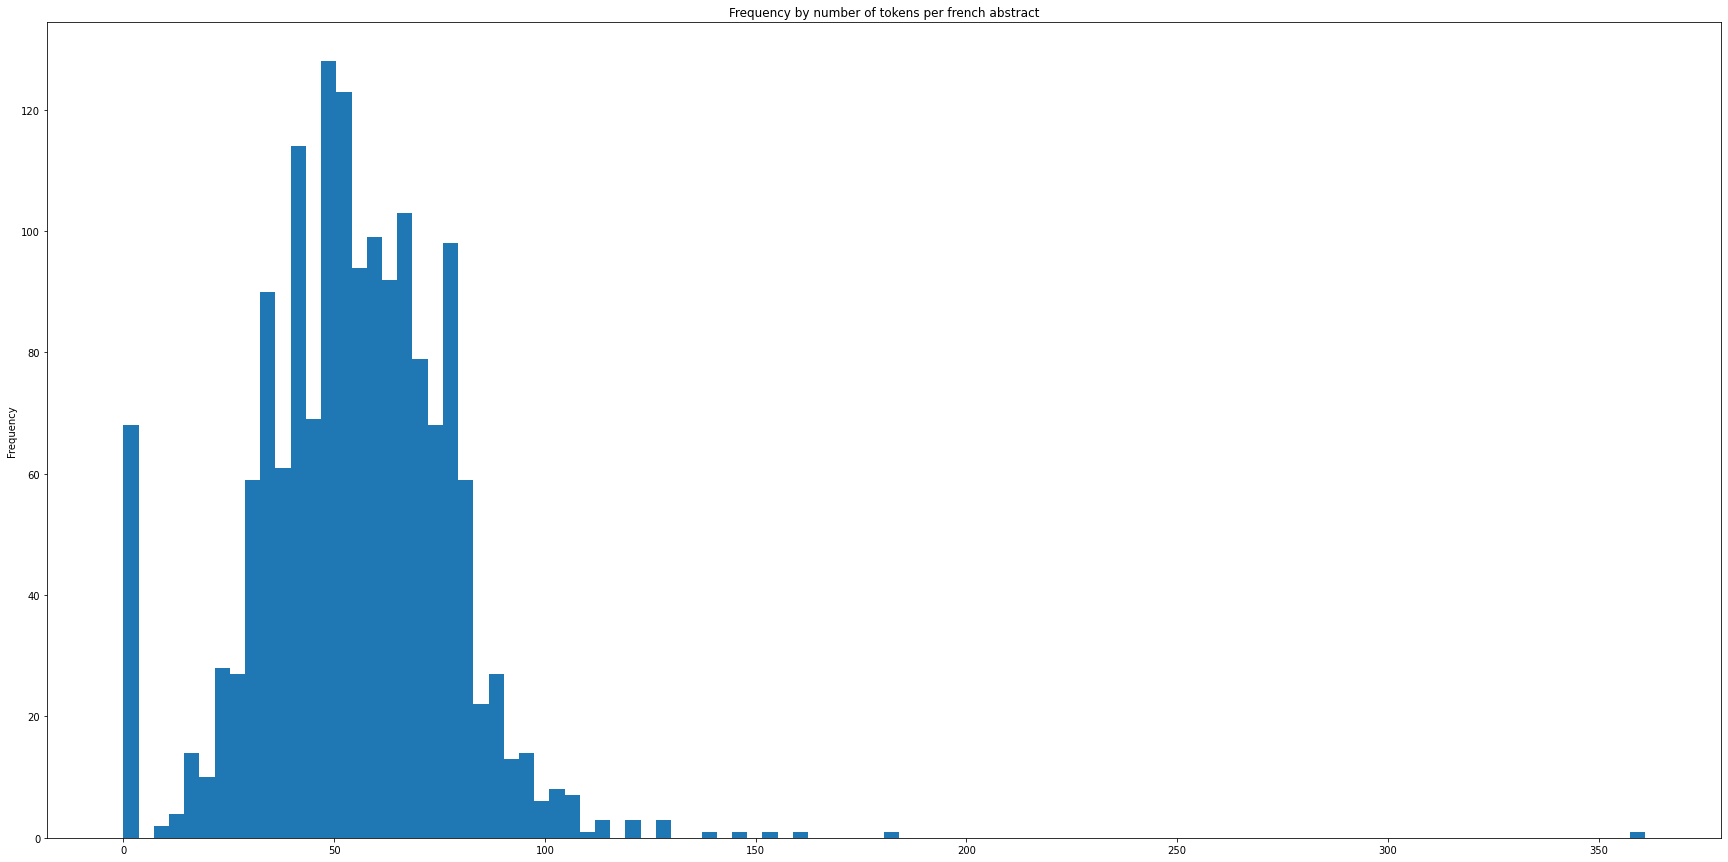

In [32]:
df_article['French Abstract Tokens'] = df_article['French Abstract'].apply(lambda x: tokenization(x))
df_article['French Abstract Length'] = df_article['French Abstract Tokens'].apply(lambda x: len(x))

df_article['French Abstract Length'].plot(kind='hist', title='Frequency by number of tokens per french abstract', figsize=(30,15), bins=100)

We observe an inferior quantity of article having a number inferior to 1O tokens in the abstract, comparing to the quantity of article having a number under 100. It's explained by the fact the article tag contain more information on the abstract.
<br>
We observe the majority of the french abstract are around 40 and 75 tokens.

We have observed that the size of the abstract is approximatively 36 times shorter than the articles

### Distribution of top unigram

Let's observe the distribution of the words in the Articles 

In [33]:
def get_top_n_words(df_column):
  corpus = [word for row in df_column for word in row]
  return Counter(corpus)


In [34]:
top_word_count = get_top_n_words(df_article['Article Tokens']).most_common(20)
top_word_count

[('corpus', 20778),
 ('mots', 16253),
 ('avons', 12291),
 ('al', 10920),
 ('exemple', 10346),
 ('été', 9538),
 ('système', 9378),
 ('résultats', 9340),
 ('même', 9134),
 ('analyse', 8856),
 ('nombre', 8129),
 ('cas', 7818),
 ('ensemble', 7757),
 ('données', 7253),
 ('modèle', 7025),
 ('type', 6589),
 ('relations', 6427),
 ('phrases', 6214),
 ('termes', 6139),
 ('permet', 5952)]

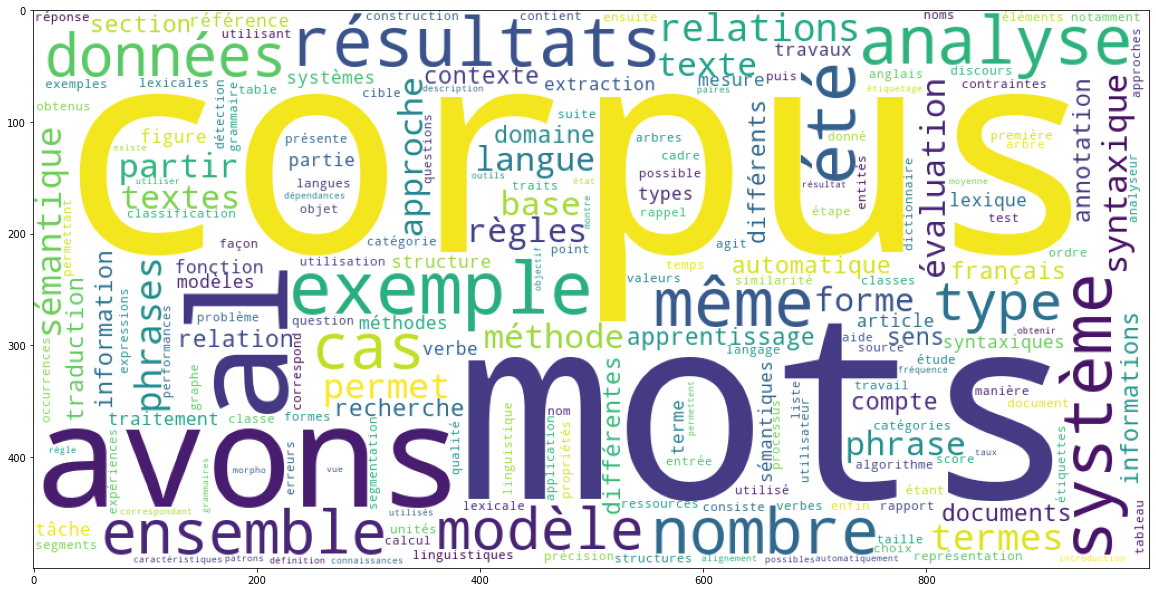

In [35]:
wordcloud = WordCloud(width = 1000, height = 500, background_color='white').generate_from_frequencies(get_top_n_words(df_article['Article Tokens']))
plt.figure(figsize=(20,15))
plt.imshow(wordcloud)

We observe the presence of the word *corpus*, really important in the NLP article, it is a language resource consisting of a large and structured set of texts.
<br>
We observe particularity of article with the presence of *al* (to quote an article), *exemple*, *modèle*.

Let's observe the distribution of the words in the french abstracts

In [36]:
get_top_n_words(df_article['French Abstract Tokens']).most_common(20)

[('corpus', 1084),
 ('article', 957),
 ('système', 704),
 ('automatique', 681),
 ('analyse', 667),
 ('résultats', 553),
 ('mots', 551),
 ('présentons', 538),
 ('méthode', 511),
 ('approche', 476),
 ('français', 450),
 ('partir', 417),
 ('textes', 416),
 ('données', 393),
 ('langue', 387),
 ('proposons', 383),
 ('traduction', 364),
 ('modèle', 362),
 ('permet', 349),
 ('sémantique', 346)]

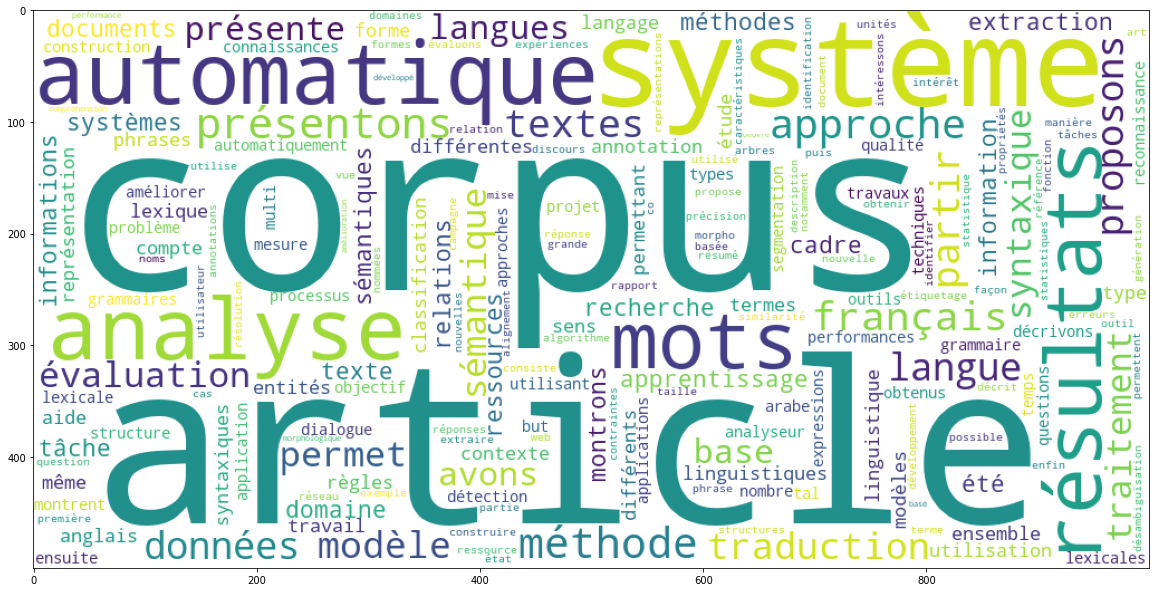

In [37]:
wordcloud = WordCloud(width = 1000, height = 500, background_color='white').generate_from_frequencies(get_top_n_words(df_article['French Abstract Tokens']))
plt.figure(figsize=(20,15))
plt.imshow(wordcloud)

We observe the big presence of the word *corpus*, *article* and *système*. these are words to talk about the article and the system made.
There is a presence of the words *automatique*, *analyse*, *approche*,*résultats*, often use in abstract.

### Distribution of keywords

Let's observe the distribution of the keyword that bring a lot of information on the dataset.
<br>
**However we must be sensitive to the fact that keyword is generated by the article writer. Spelling mistakes, plural can be present in them.** Moreover it can be a variation of the precision in the keywords.
<br>
To analyze them, we will use a pretrained word embeddings model after.

In [38]:
def keyword_tokens(keywords_list):
  """Tokenize keyword"""
  result = [clean_stopword(tokenizer.tokenize(clean_token(x))) for x in keywords_list]
  return result


def string_to_clean_list(text):
  """Transform string containing all the article keword to a list with multiple keyword"""
  list_to_replace = ['«', '»', '.', '\n', '\t']

  for char in list_to_replace:
    text = text.replace(char, '')

  text = text.replace(';',',')
  text = list(text.split(", "))

  return text

def clean_keyword(keyword):
  """Delete space at the beginning and at the end of a string"""
  return keyword.strip()

def get_top_keyword(list1):
  """Return a counter of the list"""
  corpus = [keyword for keyword in list1]
  return Counter(corpus)


In [39]:
#Filter keyword containing None
df_keywords_filtered = df_article[df_article['French Keywords'] != 'None'] 

#Transform the date column to int variable
df_keywords_filtered['Date'] = df_keywords_filtered['Date'].astype(int)

#Group by date to analyze the evolution of the keyword by date
df_date = df_keywords_filtered.groupby(['Date'])['French Keywords'].apply(lambda x: ', '.join(x))
df_date = df_date.to_frame()
df_date['Keywords separated'] = df_date['French Keywords'].apply(lambda x: string_to_clean_list(x))

for i, x in zip(range(1997,2020),df_date['Keywords separated']):
  df_date['Keywords separated'][i]=[clean_keyword(x) for x in df_date['Keywords separated'][i]]

In [40]:
#Series of the keywords per date
df_date['Keywords separated']

Date
1997                                   [None, None, None]
1998    [None, None, None, None, None, None, None, Non...
1999    [None, None, None, None, None, None, None, Non...
2000    [None, None, None, None, None, None, None, ann...
2001    [Corpus, Concordancier, TAL, Parser, Expressio...
2002    [Désambiguïsation lexicale, dictionnaire, prop...
2003    [Analyse syntaxique, Robustesse d'analyse, HPS...
2004    [Système de Question Réponse, analyse syntaxiq...
2005    [logique, grammaires minimalistes catégorielle...
2006    [collocations, acquisition semi-automatique, c...
2007    [commande en langue naturelle, analyse structu...
2008    [Recherche d'information, Traitement Automatiq...
2009    [Apprentissage automatique, classification, co...
2010    [Attribution d'auteur, modèle de langue, stylo...
2011    [Similarité, Modèle Vectoriel, Mesure de Simil...
2012    [Apprentissage non-supervisé, segmentation, ch...
2013    [Expression polylexicale, alignement bilingue,...
2014    [

In [41]:
#List of all the keywords
keyword_list = [x for list1 in df_date['Keywords separated'] for x in list1 if x != 'None']

In [42]:
#Top keyword in all the article
get_top_keyword(keyword_list).most_common(20)

[('analyse syntaxique', 46),
 ('évaluation', 44),
 ('corpus', 37),
 ("extraction d'information", 35),
 ('apprentissage automatique', 27),
 ('traduction automatique', 26),
 ('classification', 22),
 ("recherche d'information", 22),
 ('sémantique lexicale', 21),
 ('sémantique', 21),
 ("Extraction d'information", 21),
 ('entités nommées', 18),
 ('lexique', 17),
 ('annotation', 16),
 ('langue arabe', 16),
 ('TAL', 15),
 ('Entités nommées', 15),
 ('français', 15),
 ('Analyse syntaxique', 15),
 ('apprentissage', 14)]

Visualisation of the keywords in all the articles

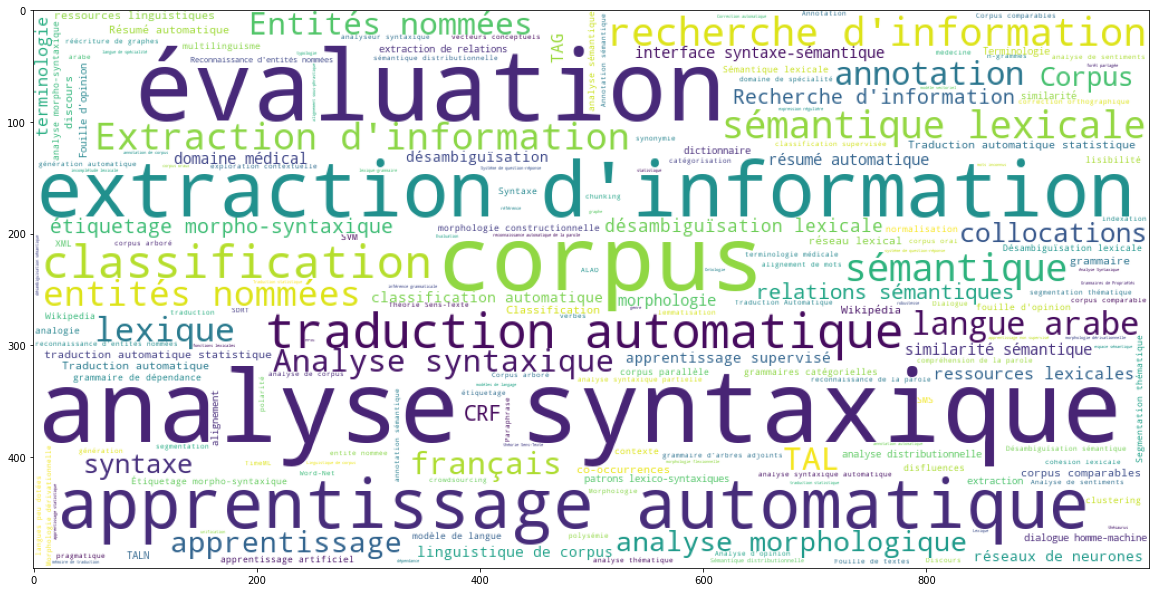

In [43]:
wordcloud = WordCloud(width = 1000, height = 500, background_color='white').generate_from_frequencies(get_top_keyword(keyword_list))
plt.figure(figsize=(20,15))
plt.imshow(wordcloud)

We observe the presence of the most generic NLP research keyword : corpus, évaluation that not bring too much information (ref: Zip'f law).
<br>
But we observe the presence of: extraction d'information, apprentissage automatique, traduction automatique... That brings information, we can analyze their evolution in the next part

### Evolution of the keyword during time

Below you can modify the keyword to observe

In [44]:
word_to_observe = 'apprentissage'

In [45]:
def keyword_evolution(word):
  number_of_apparition = [sum([1 for x in df_date['Keywords separated'][date] if word in x]) for date in range(1997,2020)]
  index_df = [i for i in range(1997,2020)]
  df_return = pd.DataFrame(number_of_apparition, columns=['Number of apparition'], index=[index_df])
  return df_return

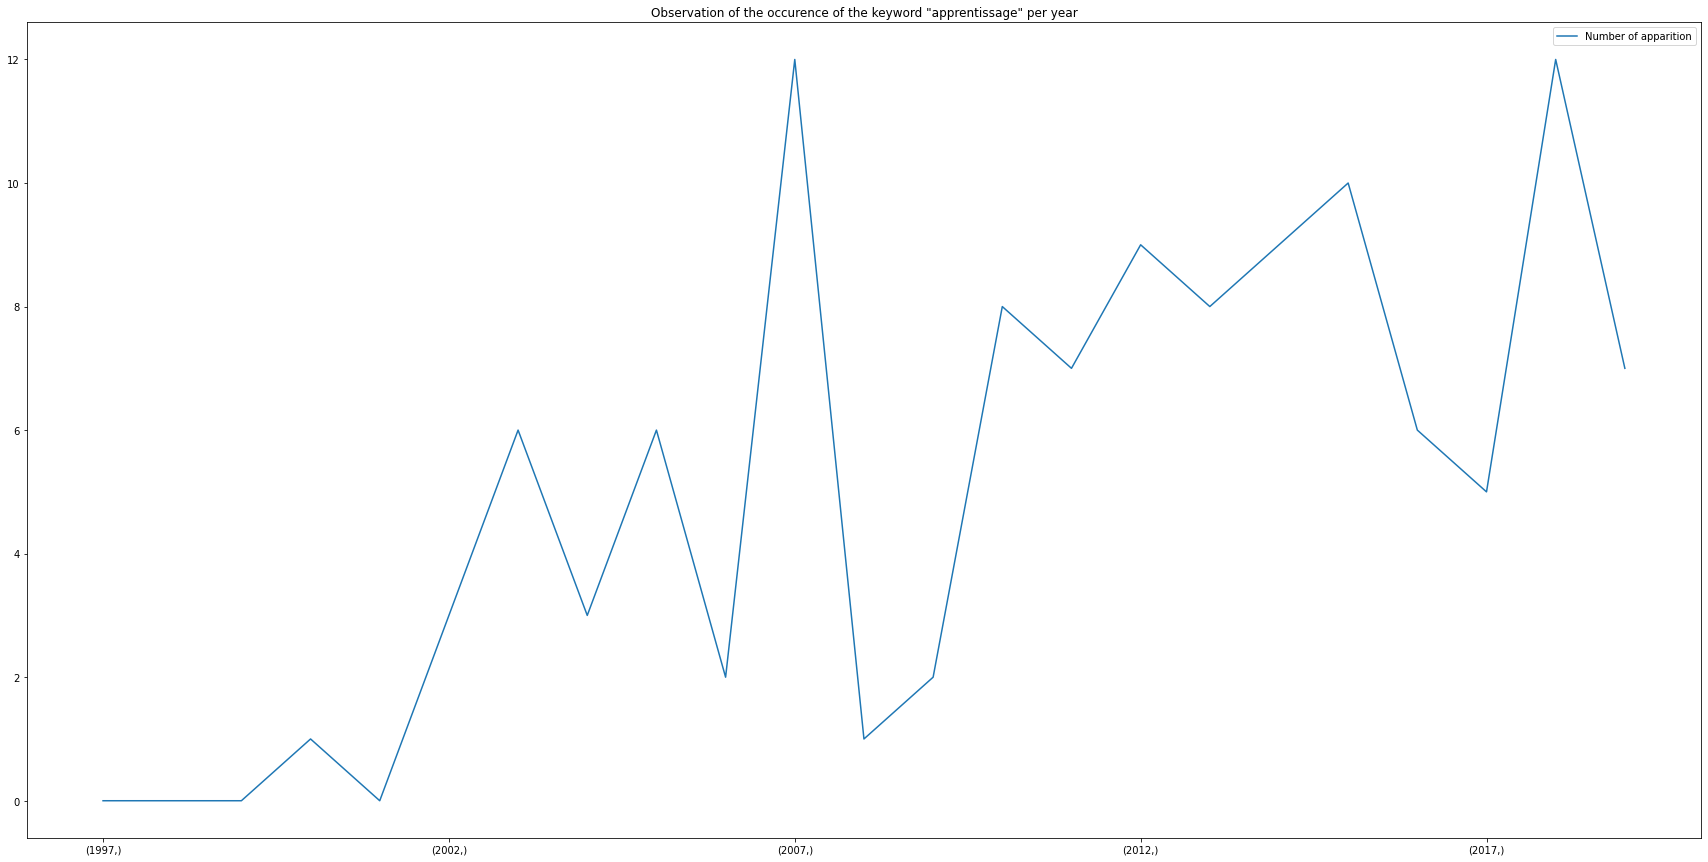

In [46]:
keyword_evolution(word_to_observe).plot(figsize=(30,15), title='Observation of the occurence of the keyword \"{}\" per year'.format(word_to_observe))

Let's normalize the occurence

In [47]:
def keyword_evolution_normalized(word):
  number_of_apparition = [sum([1 for x in df_date['Keywords separated'][date] if word in x])/len(df_date['Keywords separated'][date]) for date in range(1997,2020)]
  index_df = [i for i in range(1997,2020)]
  df_return = pd.DataFrame(number_of_apparition, columns=['Number of apparition'], index=[index_df])
  return df_return

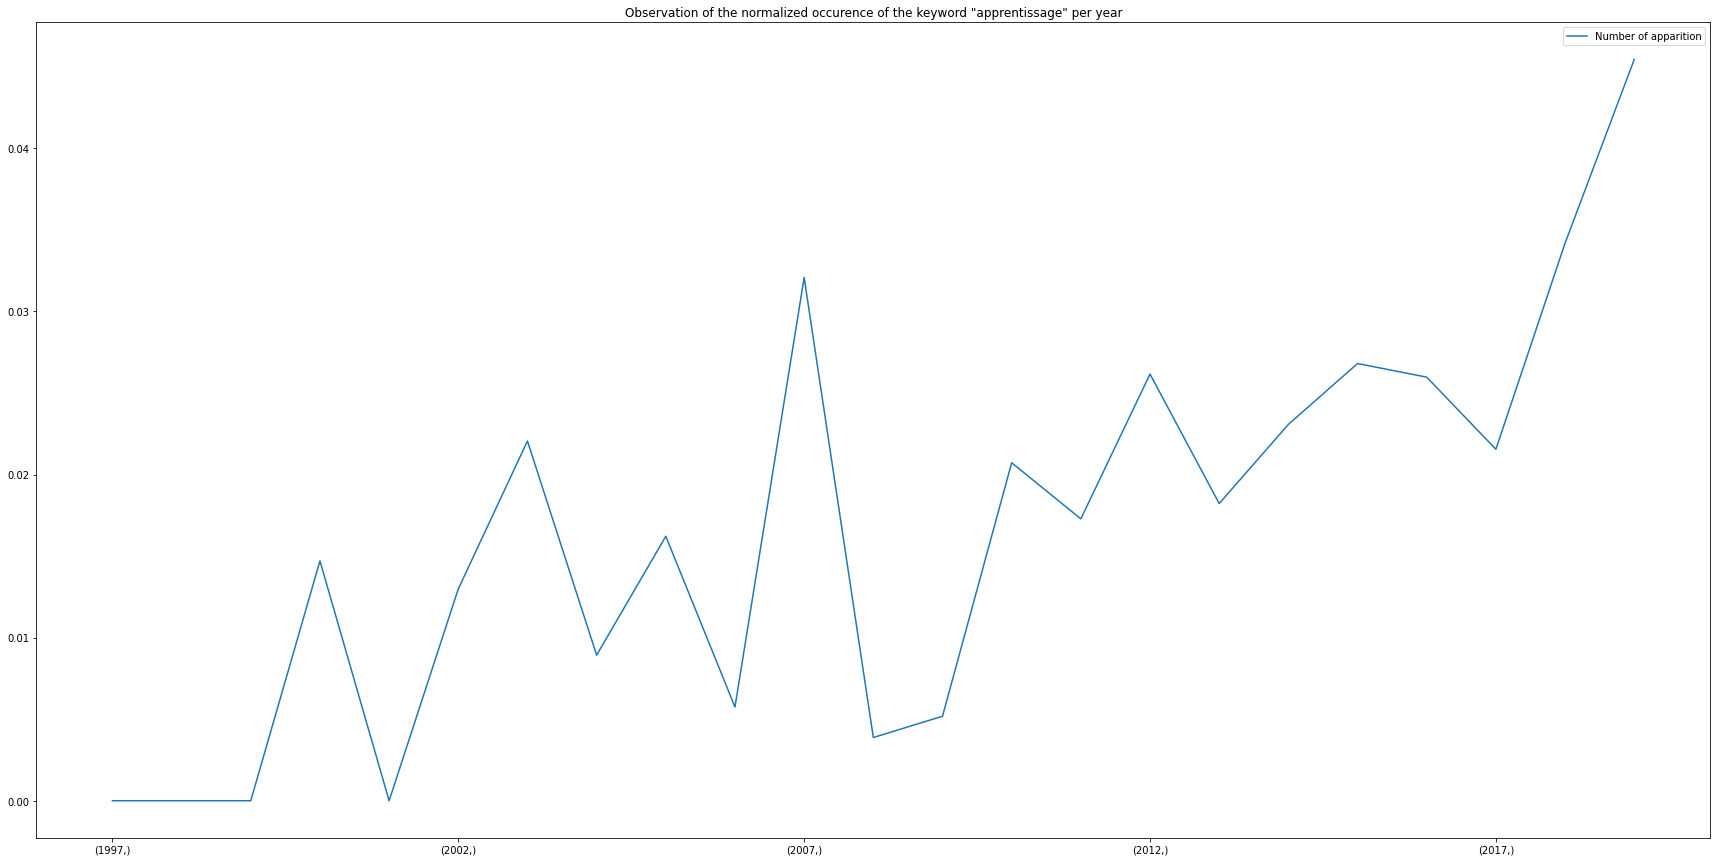

In [48]:
keyword_evolution_normalized(word_to_observe).plot(figsize=(30,15), title='Observation of the normalized occurence of the keyword \"{}\" per year'.format(word_to_observe))

We observe for the keyword 'apprentissage' a big increasing from 2010, that fits with the trend of machine learning

## Clustering of the articles using the keywords embeddings

In this part we will realize the clustering of the articles using a french pretrained embedding using their keyword and try to understand the clusters.
<br>
The pre-trained word vectors is trained on Common Crawl and Wikipedia using fastText. The model were trained using CBOW with position-weights, in dimension 300, with character n-grams of length 5, a window of size 5 and 10 negatives.

Let's vectorized the vocabulary using word embeddings

Using keyword:

In [49]:
df_keywords_filtered

Article  ... French Abstract Length
0        Architecture globale du système   Le modèle...  ...                    159
1         Introduction   Dans le domaine de l'ingéni...  ...                     14
2                                                        ...                     39
3        Introduction   La « Théorie des Représentat...  ...                     28
4        Introduction   TAG est un formalisme initia...  ...                     48
...                                                 ...  ...                    ...
1597     Introduction   L'apprentissage humain est r...  ...                     73
1598     Introduction   L'ellipse renvoie à une inco...  ...                     27
1599     Introduction   La génération automatique de...  ...                     79
1600     Introduction   L'étiquetage de séquences es...  ...                     34
1601     Contexte et motivation   Les expressions po...  ...                     66

[1602 rows x 14 columns]

In [50]:
def get_vectors(word_array):
  """Return the list of each word embeddings"""
  return [ft.get_word_vector(word) for word in word_array]

def get_vec_word(word):
  """Return the word embeddings of a word"""
  return ft.get_word_vector(word)

def Average(lst): 
  """Make average of a list"""
  return sum(lst) / len(lst) 

def embeddings(token_list):
  """Return the embeddings of a token list using the average embeddings of the word composing it"""
  try:
    emb = [get_vec_word(x) for x in token_list]
    return Average(emb)
  except:
    return []

def keyword_embeddings(token_list):
  """Make the embeddings of a list of list of tokens"""
  emb = [embeddings(x) for x in token_list]
  return emb

def mean_embeddings(array_embeddings):
  """Make the mean embedding of multiple embedding arrays"""
  return np.array(array_embeddings).sum(axis=0)/len(array_embeddings)


In [51]:
def compute_pca(X, n_components=2):
  """
  Compute the PCA for dimension reduction

  Input:
      X: of dimension (m,n) where each row corresponds to a word vector
      n_components: Number of components you want to keep.
  Output:
      X_reduced: data transformed in 2 dims/columns + regenerated original data
  """

  # mean center the data
  X_demeaned = X - np.mean(X, axis = 0)

  # calculate the covariance matrix
  covariance_matrix = np.cov(X_demeaned, rowvar = False)

  # calculate eigenvectors & eigenvalues of the covariance matrix
  eigen_vals, eigen_vecs = np.linalg.eigh(covariance_matrix)

  # sort eigenvalue in increasing order (get the indices from the sort)
  idx_sorted = np.argsort(eigen_vals)

  # reverse the order so that it's from highest to lowest.
  idx_sorted_decreasing = idx_sorted[::-1]

  # sort the eigen values by idx_sorted_decreasing
  eigen_vals_sorted = eigen_vals[idx_sorted_decreasing]

  # sort eigenvectors using the idx_sorted_decreasing indices
  eigen_vecs_sorted = eigen_vecs[:,idx_sorted_decreasing]

  # select the first n eigenvectors (n is desired dimension
  # of rescaled data array, or dims_rescaled_data)
  eigen_vecs_subset = eigen_vecs_sorted[:, 0:n_components]

  # transform the data by multiplying the transpose of the eigenvectors 
  # with the transpose of the de-meaned data
  # Then take the transpose of that product.
  X_reduced = np.transpose(np.dot(np.transpose(eigen_vecs_subset),np.transpose(X_demeaned)))


  return X_reduced

### Pre-Processing of the keywords

Let's preprocess the keywords<br>
Let's remove the 'None' value of the observation

In [52]:
#Tokenization of the keyword
keyword_tokens = df_article['French Keywords'].apply(lambda x: tokenization(x))

#Transformation to dict to remove article with unknown keywords
dict_keyword = keyword_tokens.to_dict()
dict_keyword = {key:val for key, val in dict_keyword.items() if (val != [])}

#Creation of the keyword embeddings
dict_keyword = {key:mean_embeddings(keyword_embeddings(val)) for key, val in dict_keyword.items() if (val != ['none'])}

#Transformation to series for the graphical visualization
keyword_tokens = pd.Series(dict_keyword)
keyword_tokens

24      [-0.1281357, -0.054594565, -0.08749948, -0.050...
31      [-0.13241984, -0.046640713, -0.06864144, -0.03...
40      [-0.12187441, -0.028012497, -0.080372125, -0.0...
69      [-0.114396535, -0.08344552, -0.06457652, -0.03...
72      [-0.11509011, -0.05317881, -0.10298528, 0.0044...
                              ...                        
1597    [-0.13732384, -0.076341696, -0.0830467, -0.055...
1598    [-0.13650174, -0.0743261, -0.07893202, -0.0420...
1599    [-0.13908176, -0.0586153, -0.090580516, -0.042...
1600    [-0.11996208, -0.045025073, -0.048980493, -0.0...
1601    [-0.10920918, -0.056973074, -0.026978824, -0.0...
Length: 1474, dtype: object

### Graphical visualization of highdimensional text representations

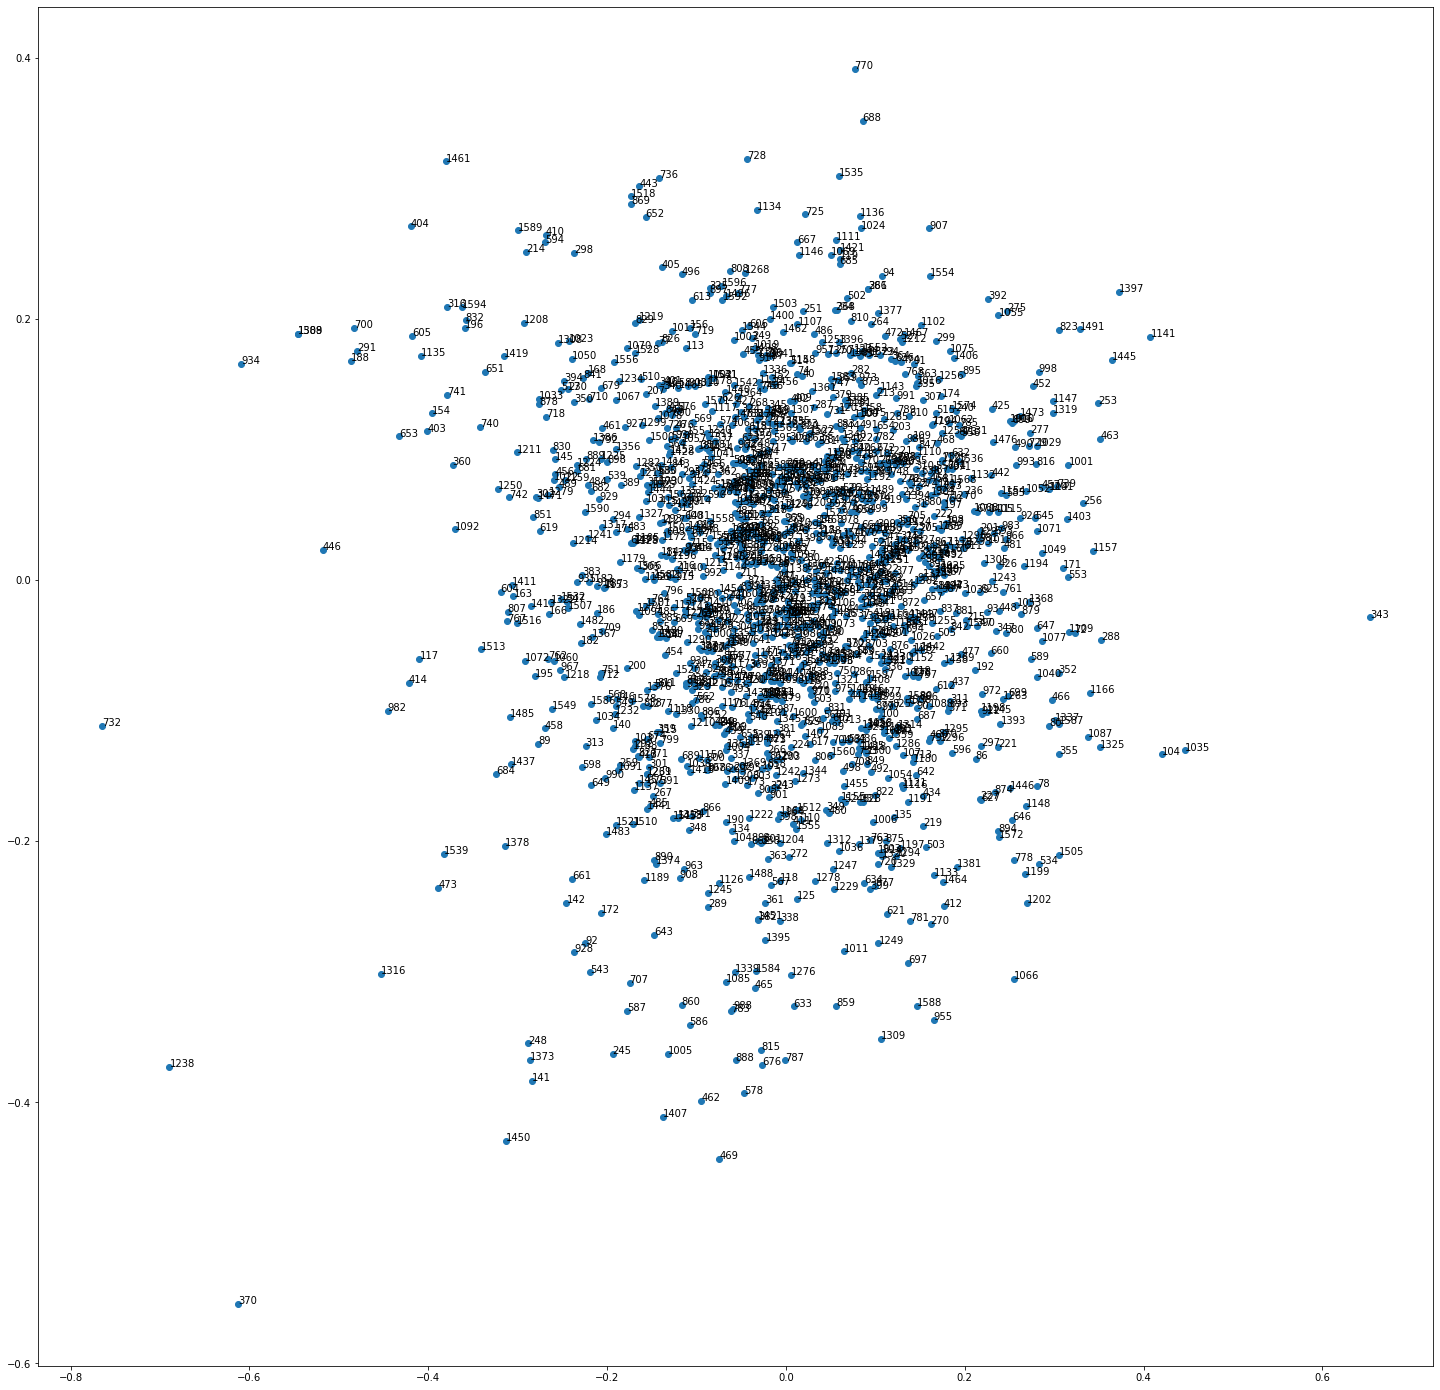

In [53]:
#Labels (article number)
keyword_index = keyword_tokens.index.tolist()

#Article embeddings list
keyword_tokens_list = keyword_tokens.tolist()

#Graphical visualization using dimensionality reduction PCA
result = compute_pca(keyword_tokens_list, n_components=2)

plt.figure(figsize=(25,25))
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(keyword_index):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
    
plt.ion()
plt.show()

### K means for clustering the embeddings

In [54]:
#Calculate Cosine Similarity
#I would use the cosine similarity since it removes the effect of document length. 
def cos_similarity(text1, text2):
  """Calculate the cosine similarity of two texts"""
  return 1 - cosine(text1, text2)

def nearest_neighbors(text1, list1, labels1):
  """Calculate the nearest article of one article"""
  distance_list = [(number, cos_similarity(text1,distance)) for number,distance in zip(labels1,list1)]
  distance_list.sort(key=lambda x:x[1], reverse=True)
  return distance_list



Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


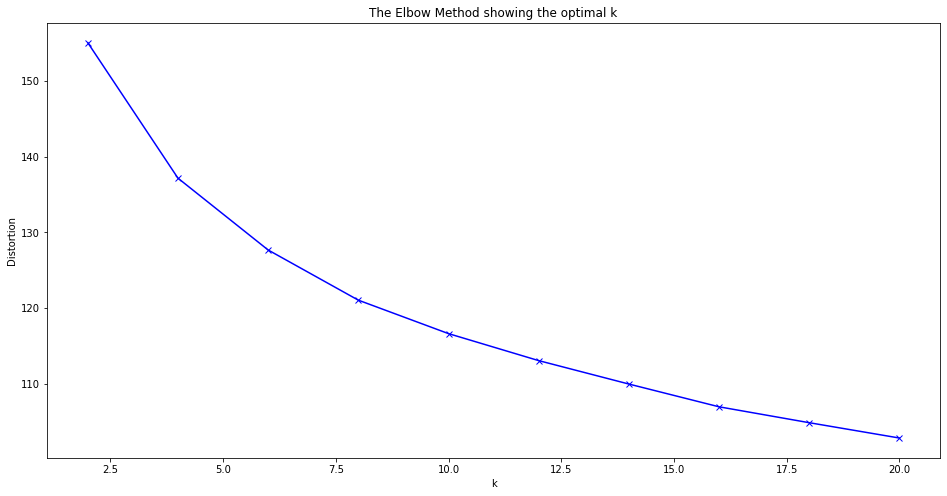

In [55]:
def elbow_method(K, data):
  """Elbow method for testing k means with many different K"""
  distortions = []
  K = range(2, K+1, 2)
  for k in K:
      kmeanModel = KMeans(n_clusters=k)
      kmeanModel.fit(data)
      distortions.append(kmeanModel.inertia_)
      print('Fit {} clusters'.format(k))
  
  plt.figure(figsize=(16,8))
  plt.plot(K, distortions, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Distortion')
  plt.title('The Elbow Method showing the optimal k')
  plt.show()

elbow_method(20, keyword_tokens_list)

We select the elbow point: 10

Let's apply a Kmeans to clusterize the article keyword embeddings into 10 clusters

In [56]:
nclusters = 10

kmeanModel = KMeans(n_clusters=nclusters)
kmeanModel.fit(keyword_tokens_list)
kmeansResult = kmeanModel.labels_

In [57]:
#Clusterization into list data structure
kmeansResultList = [(number, cluster) for number, cluster in zip(keyword_index, kmeansResult)]
article_number_cluster = []
for i in range(0,nclusters):
  [article_number_cluster.append([number[0] for number in kmeansResultList if number[1]==i])]

In [58]:
#List of list containing all the keyword per cluster
keyword_cluster = [[x for i in article_number_cluster[cluster] for x in string_to_clean_list(clean_keyword(df_article['French Keywords'][i].lower()))] for cluster in range(0,nclusters)]

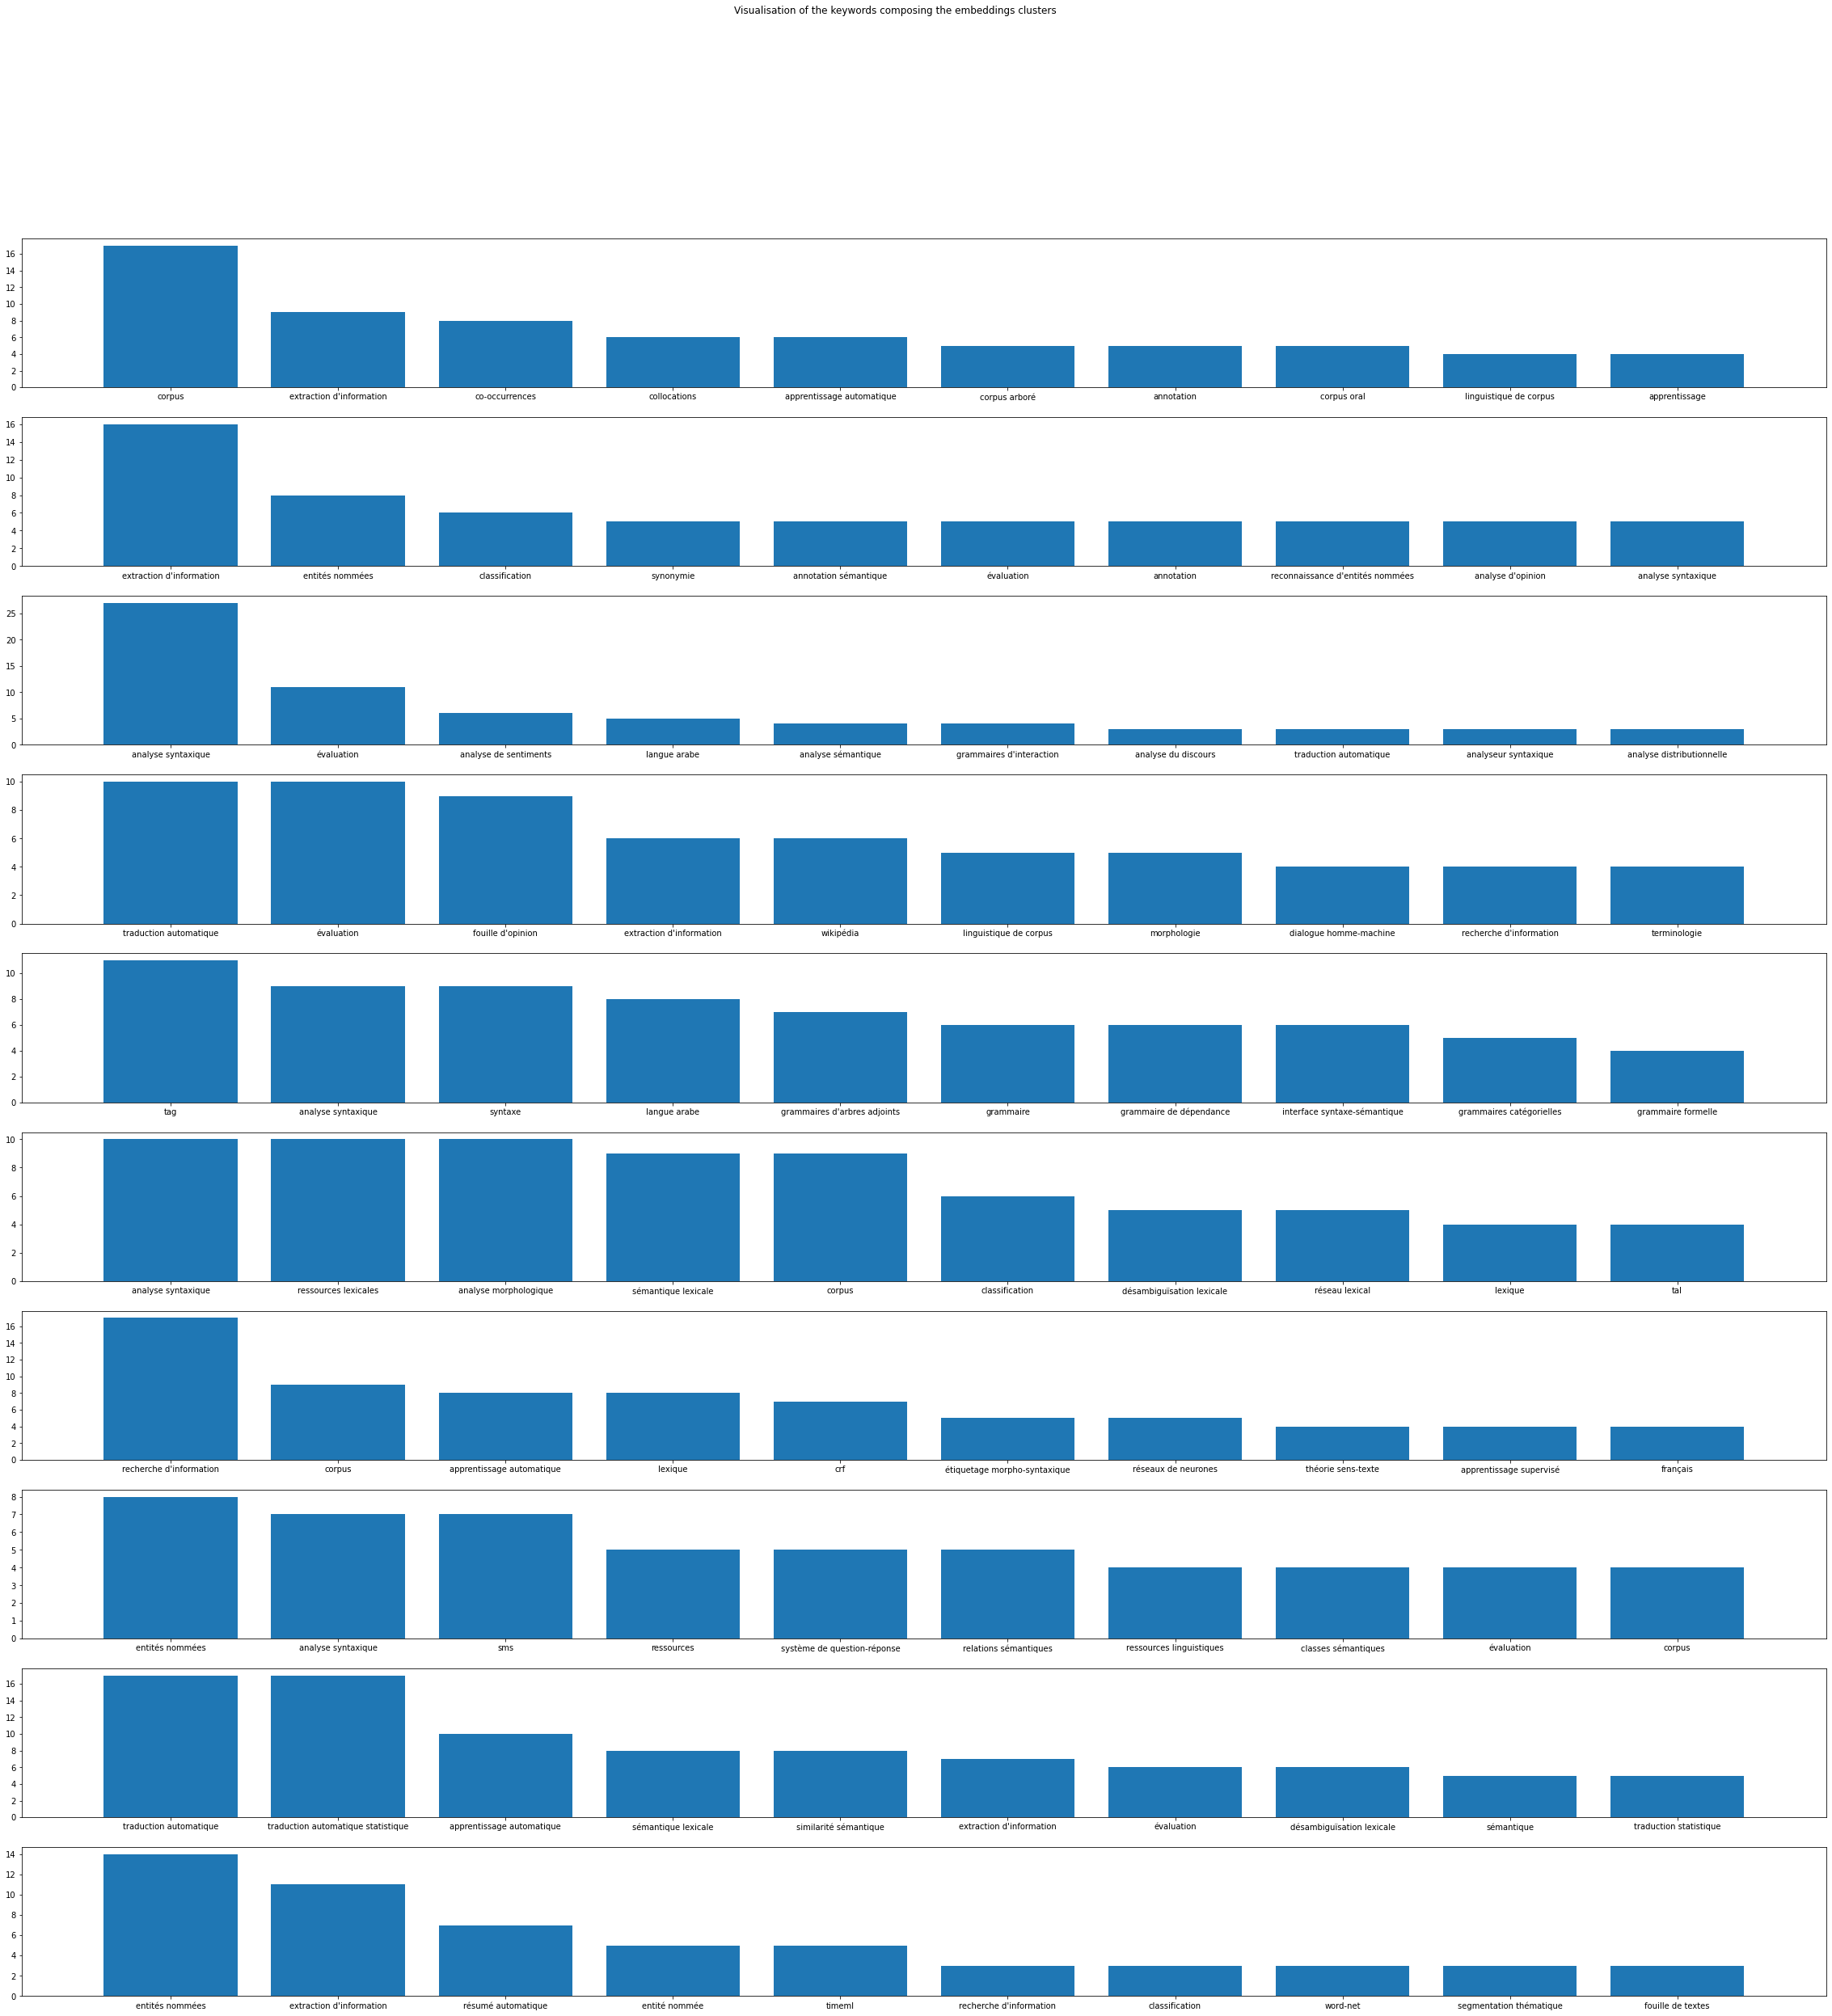

In [59]:
#Number of keyword to visualize per clusters
n_keyword_per_cluster = 10

#Visualization of the keywords
fig, axs = plt.subplots(10, figsize=(40,40))

fig.suptitle('Visualisation of the keywords composing the embeddings clusters')
for i in range(0,nclusters):
  axs[i].bar([x[0] for x in get_top_keyword(keyword_cluster[i]).most_common(n_keyword_per_cluster)], [x[1] for x in get_top_keyword(keyword_cluster[i]).most_common(n_keyword_per_cluster)])

### Analysis of the clusters and conclusion about the method

To measure the external performance of the clustering per keyword embeddings. 
We use the ground-truth trying to identify the similarity of keywords.



1.   This cluster, clusterize article about morphologie keywords, treduction and wikipedia.
2.   The presence of *Reseaux de neurones*, *Apprentissage supervisé*,*crf*,  *Apprentissage automatique* indicate the presence of similar keywords about machine learning.
3.   We identify a cluster about speech analysis, sentiment and classification.
4.   This cluster regroup article about annotations and opinion analysis
5.  Cluster about Q&A and summary, these keyword relies a lot on other keyword as *entité nommées*
6. 
7. 
8. Cluster about traduction keywords 
9. Cluster about lexicality keywords 
10.  Cluster about named entity keywords 


This method is useful to understand the similarity through the keywords and cluster the article belonging to their keywords.

Moreover it allows us to see the relationship between keywords.

Newt we will try an other clustering method using TF IDF using the entire article to see if the result is more accurate.

**Topic modeling ?** We decide to not use Topic modeling because the dataset is not appropriate and contain too much specific words.

## Clustering of articles using the content of the article

Now, we will now proceed to a clustering of our articles. This can help us to classify the articles according to the similar themes covered.

### Pre-processing

We remove the mentions or mis-scrapped emails. Then, we lower all the documents, and we remove the doubled spaces. We remove the digits, and the stop words for each article.

In [60]:
df_article['Article Processed'] = df_article['Article'].apply(lambda x: pre_process(x))
df_article.head()

Article  ...                                  Article Processed
0     Architecture globale du système   Le modèle...  ...   architecture globale du système le modèle de ...
1      Introduction   Dans le domaine de l'ingéni...  ...   introduction dans le domaine de l ingénierie ...
2                                                     ...                                                   
3     Introduction   La « Théorie des Représentat...  ...   introduction la théorie des représentations d...
4     Introduction   TAG est un formalisme initia...  ...   introduction tag est un formalisme initialeme...

[5 rows x 15 columns]

Then, we remove the empty cases

In [61]:
df_kmeans = df_article[df_article['Article Processed'] != ' ']
df_kmeans.head()

Article  ...                                  Article Processed
0     Architecture globale du système   Le modèle...  ...   architecture globale du système le modèle de ...
1      Introduction   Dans le domaine de l'ingéni...  ...   introduction dans le domaine de l ingénierie ...
3     Introduction   La « Théorie des Représentat...  ...   introduction la théorie des représentations d...
4     Introduction   TAG est un formalisme initia...  ...   introduction tag est un formalisme initialeme...
5     Introduction   L'analyse syntaxique guidée ...  ...   introduction l analyse syntaxique guidée par ...

[5 rows x 15 columns]

In [62]:
df_kmeans['Article Processed'] = df_kmeans.apply(lambda x: " ".join([stemmer.stem(word) for word in x['Article Processed'].split()]), axis = 1)
df_kmeans.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Article  ...                                  Article Processed
0     Architecture globale du système   Le modèle...  ...  architectur global du system le model de la gr...
1      Introduction   Dans le domaine de l'ingéni...  ...  introduct dan le domain de l ingénier linguist...
3     Introduction   La « Théorie des Représentat...  ...  introduct la théor de représent discurs drt in...
4     Introduction   TAG est un formalisme initia...  ...  introduct tag est un formal initial développ d...
5     Introduction   L'analyse syntaxique guidée ...  ...  introduct l analys syntax guid par le don dat ...

[5 rows x 15 columns]

### TF-IDF

We build the TF-IDF matrix from the article corpus. 

In [63]:
'''
Define vectorizer parameters : 
we set up the min and max_df to 0.2 and 0.8 in order to avoid to have miss-stemmed tokens and also miss-recognized stop words.
'''
vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.2)

X = vectorizer.fit_transform(df_kmeans['Article Processed']) #fit the vectorizer to reviews
X = X.toarray()

tfidf = pd.DataFrame(X, columns = vectorizer.get_feature_names())
tfidf

abord    absenc    accept  ...   évident      évit     évolu
0     0.072600  0.000000  0.000000  ...  0.000000  0.111712  0.000000
1     0.016544  0.000000  0.000000  ...  0.000000  0.000000  0.055474
2     0.018371  0.000000  0.014339  ...  0.012630  0.000000  0.000000
3     0.004606  0.000000  0.000000  ...  0.012666  0.007088  0.000000
4     0.006266  0.000000  0.009781  ...  0.000000  0.000000  0.000000
...        ...       ...       ...  ...       ...       ...       ...
1353  0.015579  0.007720  0.000000  ...  0.000000  0.000000  0.000000
1354  0.000000  0.038838  0.000000  ...  0.000000  0.010050  0.000000
1355  0.034193  0.000000  0.000000  ...  0.000000  0.010523  0.000000
1356  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.011671
1357  0.009381  0.006973  0.029288  ...  0.000000  0.000000  0.000000

[1358 rows x 753 columns]

### KMeans

Now, we want to cluster our papers, according to the embeddings from TF-IDF. To do so, we can use techniques such as Elbow method and Silhouette method.

#### Elbow method 

The elbow method is a heuristic used in determining the number of clusters in a data set. The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use.

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


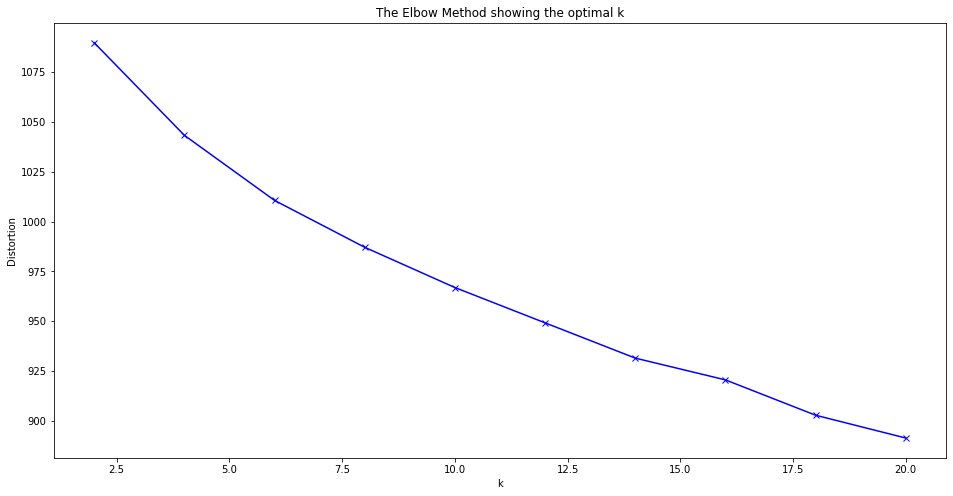

In [64]:
def elbow_method(K, data):
    distortions = []
    K = range(2, K+1, 2)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(data)
        distortions.append(kmeanModel.inertia_)
        print('Fit {} clusters'.format(k))
    
    plt.figure(figsize=(16,8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

elbow_method(20, X)

According to the plot, the elbow can be seen between 10 and 16 clusters. To be more precise, we can use the silhouette technique.

#### Silhouette method

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

For n_clusters = 2 The average silhouette_score is : 0.02385317638428322
For n_clusters = 4 The average silhouette_score is : 0.02989627017485834
For n_clusters = 6 The average silhouette_score is : 0.03478046788855283
For n_clusters = 8 The average silhouette_score is : 0.04188827948269777
For n_clusters = 10 The average silhouette_score is : 0.04566375909576832
For n_clusters = 12 The average silhouette_score is : 0.04846570031109245
For n_clusters = 14 The average silhouette_score is : 0.05204546495654182
For n_clusters = 16 The average silhouette_score is : 0.054304607537525015
For n_clusters = 18 The average silhouette_score is : 0.0567996059907768
For n_clusters = 20 The average silhouette_score is : 0.05736767199778747


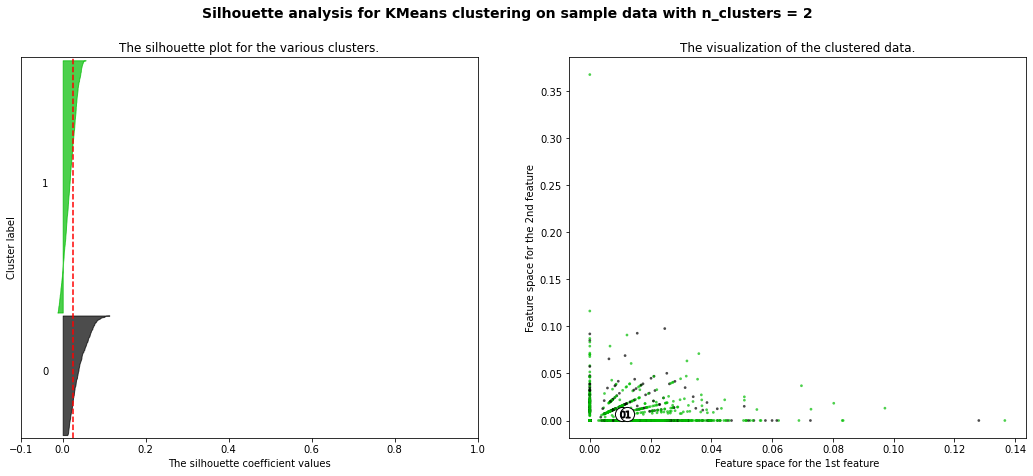

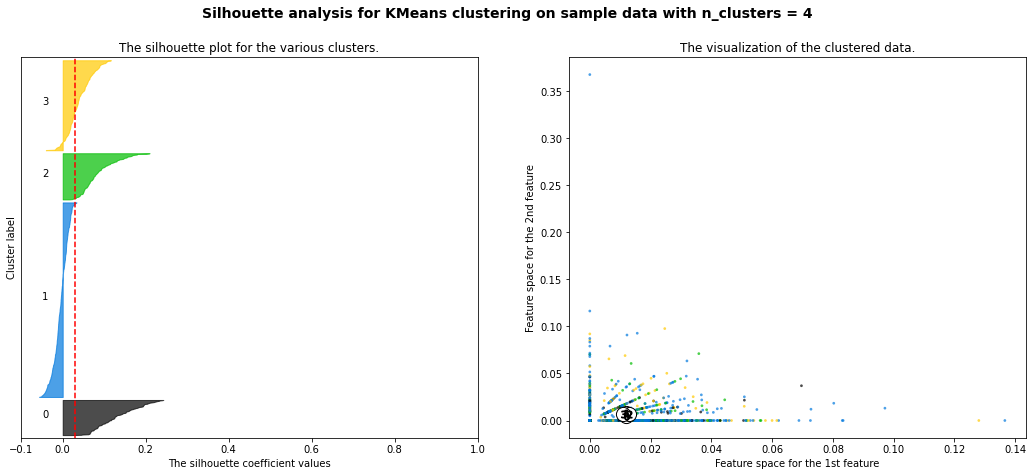

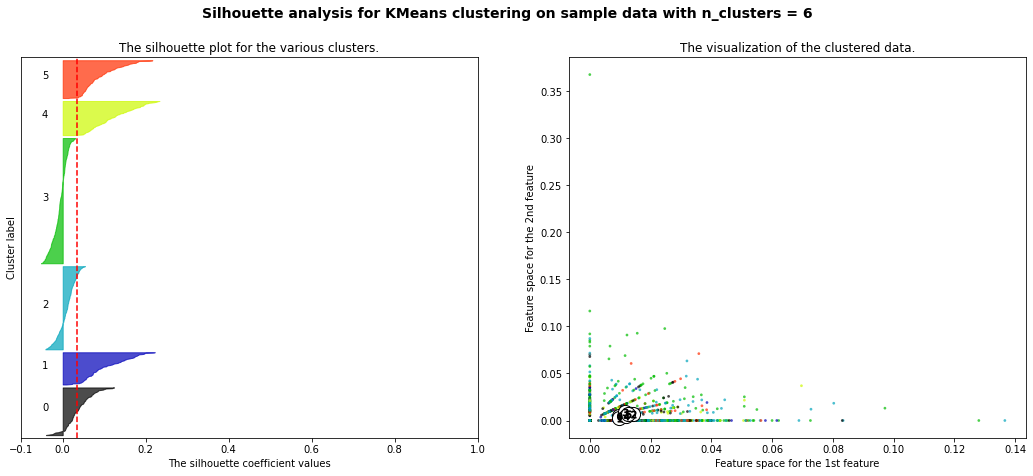

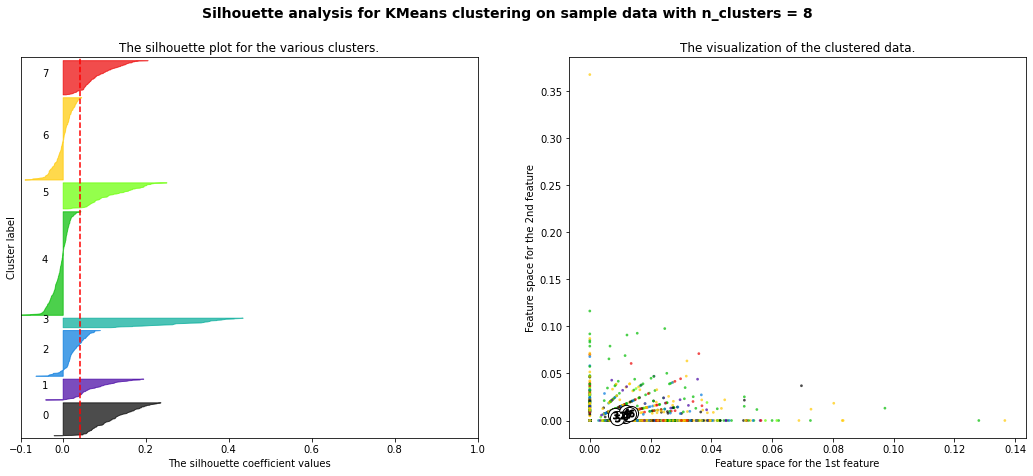

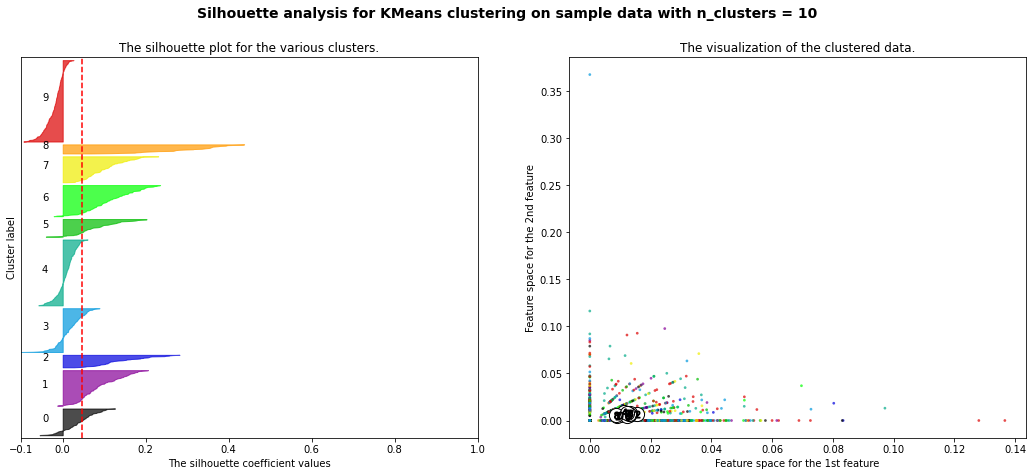

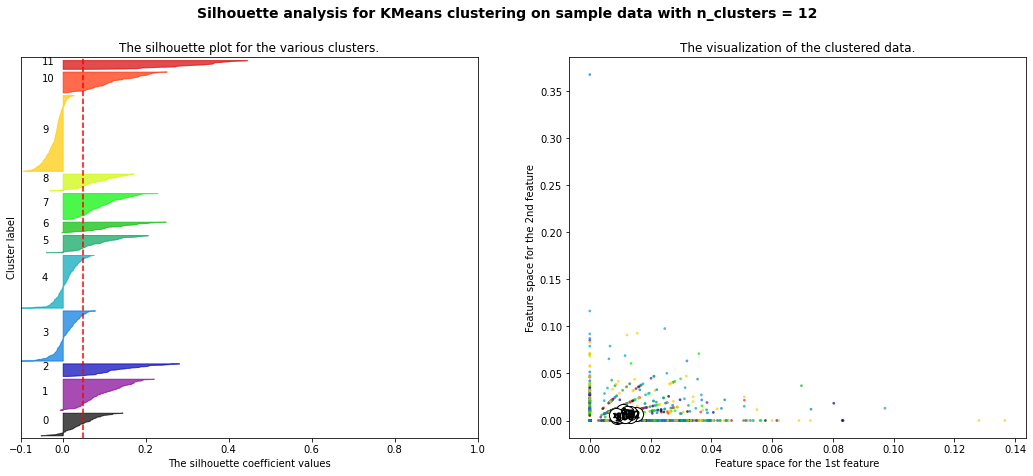

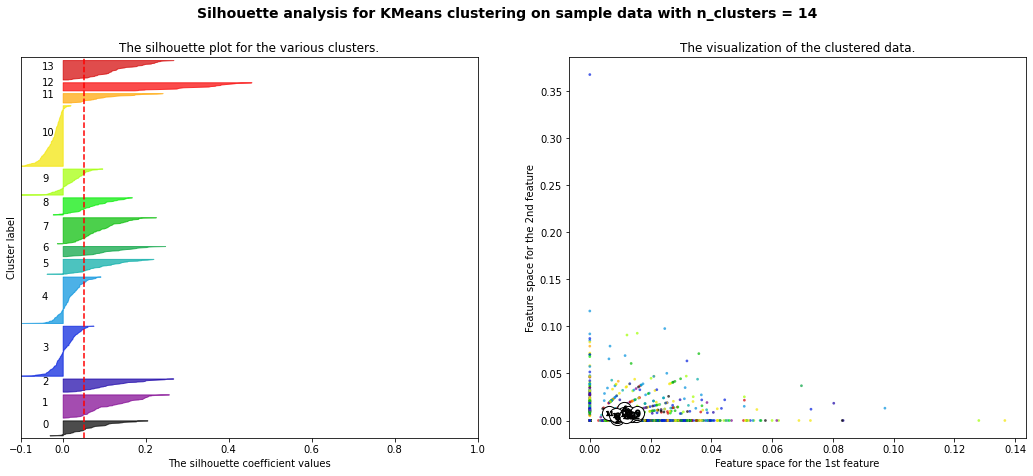

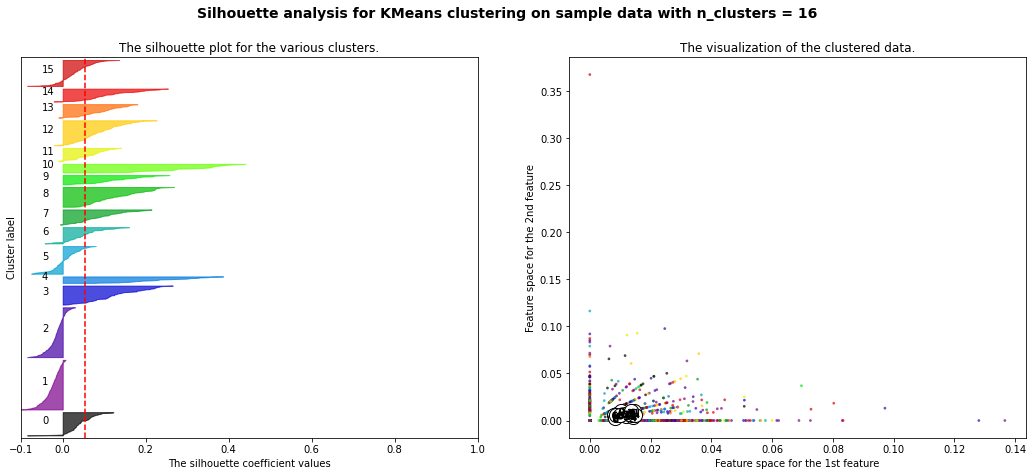

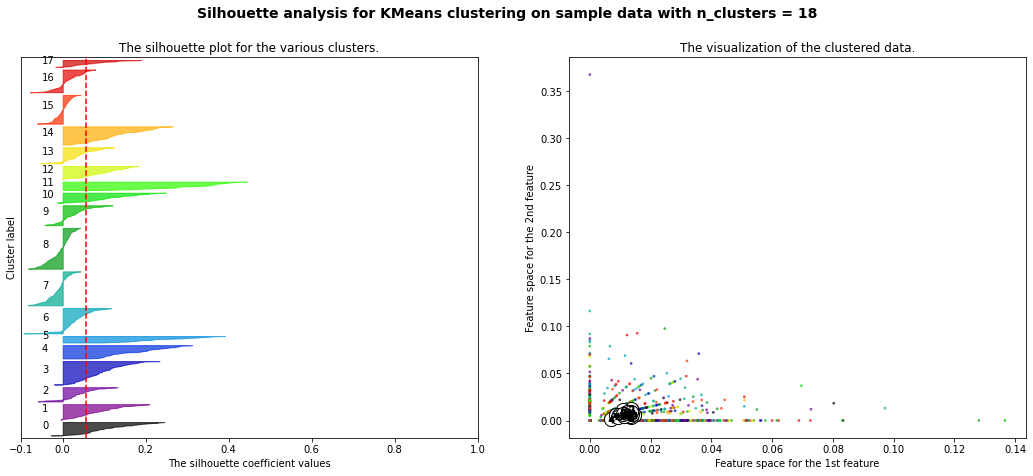

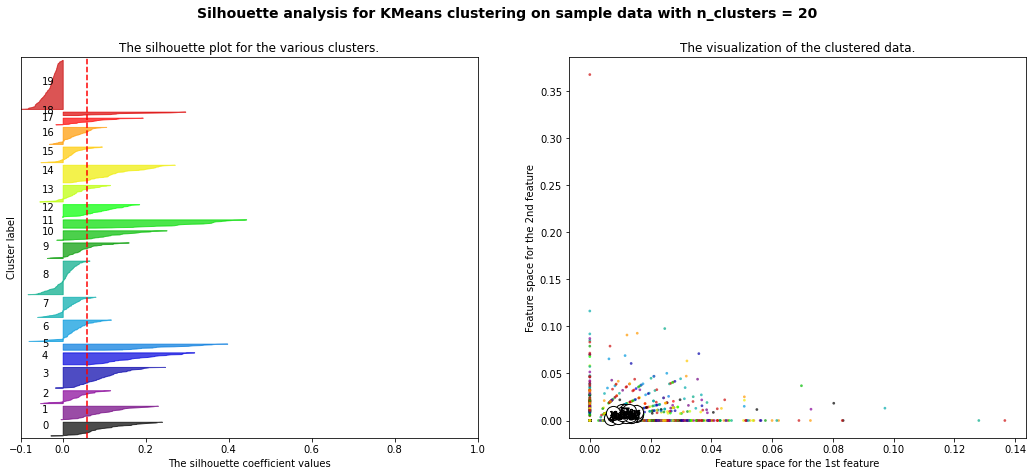

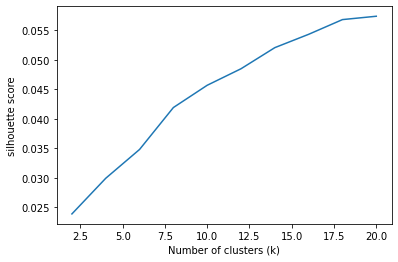

In [65]:
def silhouette_method(range_n_clusters, data):
    silhouette_avg_n_clusters = []
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(data)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(data, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        silhouette_avg_n_clusters.append(silhouette_avg)
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(data[:, 0], data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()
    plt.plot(range_n_clusters, silhouette_avg_n_clusters)
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("silhouette score")
    plt.show()
    
silhouette_method([2, 4, 6, 8, 10, 12, 14, 16, 18, 20], X)

With Silhouette, we can set our number of clusters to 16. Indeed, the score of Silhouette with 10 clusters is the best, and in the graph, the coefficients seem to be evenly distributed. However, due to the high dimensional data, the silhouette is not as accurate as we would like it to be.

#### Instanciation

Thus, we create our KMeans model with 16 clusters.

In [66]:
num_clusters = 16
km = KMeans(n_clusters=num_clusters)
km.fit(X)
clusters = km.labels_
df_kmeans['cluster'] = clusters

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### Dimensional reduction

Now, in order to have better visualization, we need to reduce the dimensions : from 749 to 3.

#### MDS

The main objective of MDS is to represent these dissimilarities as distances between points in a low dimensional space such that the distances correspond as closely as possible to the dissimilarities.

In [67]:
dist = 1 - cosine_similarity(tfidf)

MDS()

# convert three components as we're plotting points in a three-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify random_state so the plot is reproducible.

mds = MDS(n_components=3, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

### Visualization 

Finally, with the dimensionality reduction we perform earlier, we are able to represent in a 3D plot, the different clusters and their space representation. As we can see, KMeans performed very well, because articles belonging to the same cluster are close in the graph.

In [68]:
xs, ys, zs = pos[:, 0], pos[:, 1], pos[:,2]


df_plot3d = pd.DataFrame(list(zip(xs, ys, zs, clusters)), columns =['xs', 'ys', 'zs', 'clusters'])


import plotly.express as px

fig = px.scatter_3d(df_plot3d, x = 'xs',  
                    y = 'ys',  
                    z = 'zs', 
                    color = 'clusters',
                    title='3D scatter plot'
                    ) #text="title"
  
fig.show()

### Validation

In [69]:
df_kmeans.head()

Article  ... cluster
0     Architecture globale du système   Le modèle...  ...       0
1      Introduction   Dans le domaine de l'ingéni...  ...       3
3     Introduction   La « Théorie des Représentat...  ...       5
4     Introduction   TAG est un formalisme initia...  ...       2
5     Introduction   L'analyse syntaxique guidée ...  ...       2

[5 rows x 16 columns]

In [70]:
articles = df_kmeans.groupby('cluster')['Article Processed'].apply(list)
articles

cluster
0     [architectur global du system le model de la g...
1     [introduct l object du trait automat du langag...
2     [introduct tag est un formal initial développ ...
3     [introduct dan le domain de l ingénier linguis...
4     [introduct la techniqu text to speech pour la ...
5     [introduct la théor de représent discurs drt i...
6     [le paradigm d évalu bref histor l évalu compa...
7     [introduct cet articl présent iliad une chaîn ...
8     [introduct cet articl présent la démarch suiv ...
9     [introduct dan le cadr du trait automat de la ...
10    [introduct et présent général du system le pro...
11    [introduct le tagging ou étiquetag ou marquag ...
12    [introduct la descript d itinérair est d un in...
13    [introduct plusieur auteur dorr saint dizi vic...
14    [introduct le model de langag utilis dan le sy...
15    [introduct dan le cadr de la conférent d évalu...
Name: Article Processed, dtype: object

Due to a memory problem, we cannot calculate the word distribution to validate our clustering. However, if we can have this distribution, we would be able to label our clusters, just like we did with keyword clustering.

## Auto summarizer of articles

Using TextRank, we'll perform a summarizer. Text Summarization is one of those applications of Natural Language Processing (NLP) which is bound to have a huge impact on our lives. With growing digital media and ever growing publishing – who has the time to go through entire articles / documents / books to decide whether they are useful or not? Thankfully – this technology is already here.

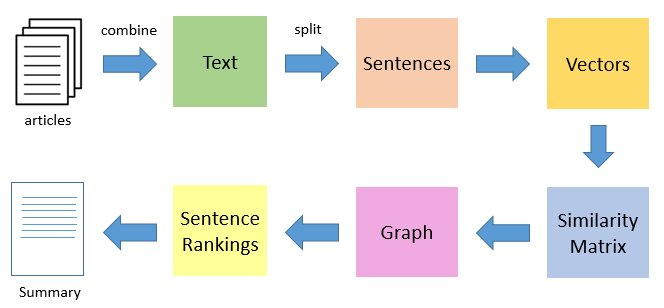

*   The first step would be to concatenate all the text contained in the articles
*   Then split the text into individual sentences
*   In the next step, we will find vector representation (word embeddings) for each and every sentence
*   Similarities between sentence vectors are then calculated and stored in a matrix
*   The similarity matrix is then converted into a graph, with sentences as vertices and similarity scores as edges, for sentence rank calculation
*   Finally, a certain number of top-ranked sentences form the final summary

In [71]:
# We create a class in order to be able to handle different languages for the summarizer : stopwords and a stemmer

class LanguageProcessor(object):
  def __init__(self, language):
      self.language = language
      self.stopwords = corpus.stopwords.words(language)
      self.stemmer = stem.SnowballStemmer(language)

  def split_sentences(self, text):
    '''
    Function to split sentences of the text

    args: text
    return: all the different sentences of the text
    '''
    return tokenize.sent_tokenize(text, self.language)

  def extract_significant_words(self, sentence):
    '''
    Function to extract the significant words of a sentence, i.e the word which hold most of the sense of the sentence
    We remove the alpha numeric caracters and the stopwords

    args: sentence
    return: a set of significant word of the sentence
    '''
    return set(
        word for word in tokenize.word_tokenize(sentence)
        if word.isalnum() and word not in self.stopwords
    )

  def stem(self, word):
    '''
    Function to create stem a given word

    args: word
    return: word stemmed
    '''
    return self.stemmer.stem(word)

In [72]:
def summarize(text, sentence_count=5, language='english'):
  '''
  Function to summarize in a given number of sentence and a given language a text
  The goal is a create a similarity graph using cosine metrics between sentences.
  Then, we apply the pagerank algorithm in order to get the best sentences (i.e the ones which hold most of the 
  sence of the text).

  args: - text
        - sentence_count
        - language
  
  return: the text summarized
  '''
  processor = LanguageProcessor(language)

  sentence_list = processor.split_sentences(text)
  wordset_list = map(processor.extract_significant_words, sentence_list)
  stemsets = [
      {processor.stem(word) for word in wordset}
      for wordset in wordset_list
  ]

  graph = Graph()
  pairs = combinations(enumerate(stemsets), 2)
  for (index_a, stems_a), (index_b, stems_b) in pairs:
      if stems_a and stems_b:
          similarity = 1 - jaccard(stems_a, stems_b)
          if similarity > 0:
              graph.add_edge(index_a, index_b, weight=similarity)

  ranked_sentence_indexes = list(pagerank(graph).items())
  if ranked_sentence_indexes:
      sentences_by_rank = sorted(
          ranked_sentence_indexes, key=itemgetter(1), reverse=True)
      best_sentences = map(itemgetter(0), sentences_by_rank[:sentence_count])
      best_sentences_in_order = sorted(best_sentences)
  else:
      best_sentences_in_order = range(min(sentence_count, len(sentence_list)))

  return ' '.join(sentence_list[index] for index in best_sentences_in_order)

In [73]:
summarize(df_article['Article'][0], sentence_count = 10, language = 'french')

'A partir de ce principe, défini comme un « processus informatique de changements de représentations qui crée des représentations intermédiaires à différents niveaux » [DES 96, p. 105 est élaborée une architecture informatique d\'interprétation sémantique des textes par des représentations iconiques (Fig. Ce module construit une représentation sémantico-cognitive globale du texte en prenant en compte (i) la valeur aspecto-temporelle de chaque énoncé et (ii) le sens de chaque prédicat verbal appliqué à ses arguments. La représentation sémantico-cognitive du texte construite à l\'issue de cette analyse s\'appuie donc sur les seules connaissances linguistiques, et revêt la forme d\'une séquence discrète de situations. La représentation du mouvement dans la langue   Comme tout processus, le mouvement spatial "consomme" du temps. Le diagramme temporel (Fig.4) du texte obtenu à l\'issue de cette analyse représente les relations inter-propositionnelles telles que la concomitance, l\'inclusion

In [74]:
tmp = df_kmeans['Article'][df_kmeans['cluster'] == 0][:10].tolist()
articles = " ".join(tmp)

In [75]:
summarize(articles, sentence_count = 15, language = 'french')

'Les composants et les exigences du système   Si l\'on considère qu\'un système d\'extraction automatique de réponses doit être capable de traiter des textes très techniques, il a besoin d\'un module très fiable qui réalise toutes les segmentations en mots et en phrases d\'un texte (qu\'on appellera dans ce qui suit segmenteur, "tokeniser" en anglais une grammaire ayant une large couverture, un analyseur syntaxique assez robuste, un traitement des ambiguïtés, un module qui permet de construire une représentation sémantique à partir des structures syntaxiques des phrases, et un moteur de recherche capable d\'utiliser ces représentations sémantiques. En effet, c\'est cette partie de la phrase qui donne une réponse plus directe à la question. Le système construit sa connaissance par interaction avec l\'expert de la base de données. Plus précisément, ces traitements sont associés aux opérateurs linguistiques par l\'administrateur de la base de données lors de l\'installation du système sur

A summary could be made of our different clusters, but due to computation power limits of Google Colab, we can only make a summury of a given number of abstracts/articles of a given cluster. But this method could show promising results if we could perform it on all the articles of each cluster, in order to better validate our kmeans clustering than using distribution of words.

## References

**Dataset:**


@InProceedings{TanguyFabreBard2020, author = {Ludovic Tanguy and Cécile Fabre and Yoann Bard}, title = {Impact de la structure logique des documents sur les modèles distributionnels~: expérimentations sur le corpus TALN}, booktitle = {Actes de TALN}, year = 2020, address = {Nancy}}
Cognition, Langue, Langages, Ergonomie - UMR 5263 (CLLE) (2020). Corpus TALN [Corpus]. ORTOLANG (Open Resources and TOols for LANGuage) - www.ortolang.fr, v1, https://hdl.handle.net/11403/corpus-taln/v1.
<br><br>
**References of methods used:**

P. Bojanowski*, E. Grave*, A. Joulin, T. Mikolov, Enriching Word Vectors with Subword Information

A. Joulin, E. Grave, P. Bojanowski, T. Mikolov, Bag of Tricks for Efficient Text Classification

A. Joulin, E. Grave, P. Bojanowski, M. Douze, H. Jégou, T. Mikolov, FastText.zip: Compressing text classification models

The global k-means clustering algorithm, Aristidis Likasa, Nikos Vlassisb, JakobJ. Verbeekb
<br><br>
**Internet blog pages:**

https://en.wikipedia.org/wiki/Text_corpus


